In [10]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from yellowbrick.cluster import SilhouetteVisualizer

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

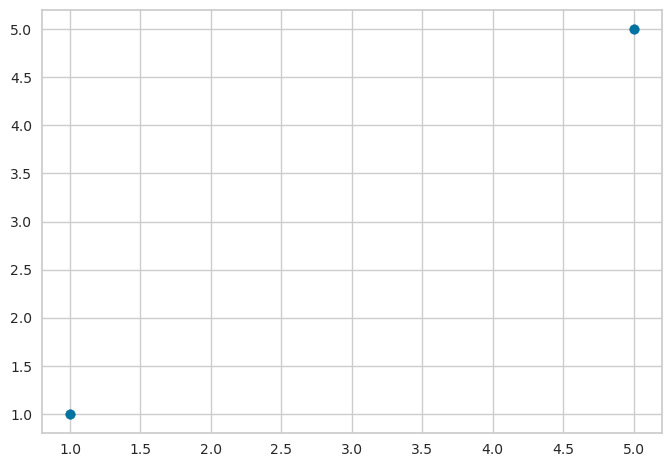

In [11]:
plt.scatter([1,5], [1,5])

In [ ]:

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Classes

In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## PCA

In [3]:
class c_PCA :
    def __init__(self, df, columns, n_components=6):
        self.df = df[columns]
        self.columns = columns
        self.n_components = n_components
        self.X = self.df.values 
        self.X_scaled = None
        self.X_scaled_verif = None
        self.pca = None
        self.pcs = None
    
   
    def scale(self,scalertype):
        scaler = scalertype
        scaled_features = scaler.fit(self.X)
        self.X_scaled = scaled_features.transform(self.X)
        self.X_scaled_verif = pd.DataFrame(self.X_scaled).describe().round(2).loc[["mean", "std"], :]
        

    def pca_evr(self):
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(self.X_scaled)
        
        self.pcs = self.pca.components_
        self.pcs = pd.DataFrame(self.pcs, columns=self.columns)
        self.pcs.index = [f"F{i+1}" for i in range(self.n_components)]
        self.pcs = self.pcs.round(2)
        
        evr = (self.pca.explained_variance_ratio_*100).round(2)
        print("Explained variance ratio: ", evr)
        evr_cum = evr.cumsum().round()
        print("Cumulative explained variance ratio: ", evr_cum)
        
        x_list = range(1,self.n_components+1)
        
        plt.bar(x_list, evr)
        plt.plot(x_list, evr_cum,c="red",marker='o')
        plt.xlabel("rang de l'axe d'inertie")
        plt.ylabel("pourcentage d'inertie")
        plt.title("Eboulis des valeurs propres")
        plt.show(block=False)
        

    def correlation_circle(self,
                           ax,
                           x_y) : 
        """Affiche le graphe des correlations

        Positional arguments : 
        -----------------------------------
        pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
        x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
        features : list ou tuple : la liste des features (ie des dimensions) à représenter
        """

        # Extrait x et y 
        x,y=x_y

        # Pour chaque composante : 
        for i in range(0, self.pca.components_.shape[1]):

            # Les flèches
            ax.arrow(0,0, 
                    self.pca.components_[x, i],  
                    self.pca.components_[y, i],  
                    head_width=0.07,
                    head_length=0.07, 
                    width=0.02, )

            # Les labels
            plt.text(self.pca.components_[x, i] + 0.05,
                    self.pca.components_[y, i] + 0.05,
                    self.columns[i])
            
        # Affichage des lignes horizontales et verticales
        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        # Nom des axes, avec le pourcentage d'inertie expliqué
        plt.xlabel('F{} ({}%)'.format(x+1, round(100*self.pca.explained_variance_ratio_[x],1)))
        plt.ylabel('F{} ({}%)'.format(y+1, round(100*self.pca.explained_variance_ratio_[y],1)))

        # J'ai copié collé le code sans le lire
        plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

        # Le cercle 
        an = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

        # Axes et display
        plt.axis('equal')
        plt.show(block=False)
        
   
    def display_factorial_planesi(self,ax, x_y,
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                marker="." ):
        """
        Affiche la projection des individus

        Positional arguments : 
        -------------------------------------
        X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
        x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

        Optional arguments : 
        -------------------------------------
        pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
        labels : list ou tuple : les labels des individus à projeter, default = None
        clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
        alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
        marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
        """

        X_projected = self.pca.transform(self.X_scaled)
        # Transforme X_projected en np.array
        X_ = np.array(X_projected)

        # On gère les labels
        if  labels is None : 
            labels = []
        try : 
            len(labels)
        except Exception as e : 
            raise e

        # On vérifie la variable axis 
        if not len(x_y) ==2 : 
            raise AttributeError("2 axes sont demandées")   
        if max(x_y )>= X_.shape[1] : 
            raise AttributeError("la variable axis n'est pas bonne")   

        # on définit x et y 
        x, y = x_y

        # On vérifie s'il y a des clusters ou non
        c = None if clusters is None else clusters
    
        # Les points    
        # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
        #                     c=c, cmap="Set1", marker=marker)
        sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())

        # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
        v1 = str(round(100*self.pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*self.pca.explained_variance_ratio_[y]))  + " %"


        # Nom des axes, avec le pourcentage d'inertie expliqué
        ax.set_xlabel(f'F{x+1} {v1}')
        ax.set_ylabel(f'F{y+1} {v2}')

        # Valeur x max et y max
        x_max = np.abs(X_[:, x]).max() *1.1
        y_max = np.abs(X_[:, y]).max() *1.1

        # On borne x et y 
        ax.set_xlim(left=-x_max, right=x_max)
        ax.set_ylim(bottom= -y_max, top=y_max)

        # Affichage des lignes horizontales et verticales
        plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
        plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

        # Affichage des labels des points
        if len(labels) : 
            # j'ai copié collé la fonction sans la lire
            for i,(_x,_y) in enumerate(X_[:,[x,y]]):
                plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

        # Titre et display
        plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
        plt.show()
        
        

## CAH

In [4]:
class CAH :
    def __init__(self,df,columns):
        self.df = df[columns]
        self.colmuns = columns
        self.Z = None
        self.df_mean_std = None
        self.clusters = None
    
    def scale(self,scalertype : StandardScaler)->None:
        """
        This function scales the data using the scaler type provided as input. 
        We are also creating a short DataFrame with the mean and standard deviation of the scaled data.
        
        Parameters:
            scalertype (StandardScaler) : scaler type to use for scaling the data
        
        Returns:
            None
        """
        #Put values in the scaler, fit and transform
        X = self.df.values
        scaler = scalertype
        scaled_features = scaler.fit(X)
        X_scaled = scaled_features.transform(X)
        #Linkage using ward method
        self.Z = linkage(X_scaled, method='ward')
        # Short DataFrame with mean and std to verify the scaling
        self.df_mean_std = pd.DataFrame(X_scaled).describe().round(2).iloc[1:3:, : ]
        
    def dendrogram(self,ax,title='Dendogram',xlabel='Distance',ylabel='Individus',labelsize=5):
        '''This function plots the dendrogram. Subplot should be created before calling this function, providing the ax parameter.
            input: ax, title, xlabel, ylabel, labelsize
        '''
        _ = dendrogram(self.Z, ax=ax, labels=self.df.index, orientation = "top")
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.tick_params(axis='x', which='major', labelsize=labelsize)
        ax.tick_params(axis='y', which='major', labelsize=labelsize)
        
    def cluster(self,n_clusters):
        '''This function clusters the data using the number of clusters provided as input. This number is chosen by the user reviewing the dendogram.
            input: n_clusters
        '''
        clustering_model = AgglomerativeClustering(n_clusters=n_clusters, linkage = "ward")
        clustering_model.fit(self.df.values)
        self.clusters = clustering_model.labels_

## Kmeans

In [5]:
class kmeans :
    def __init__(self,df,columns):
        self.df = df[columns]
        self.colmuns = columns
        self.clusters = []
            
    def plot_inertia(self,ax,title="Inertia",k_max=10):
        '''This function plots the inertia for each k value, from 2 to k_max. Using the elbow method will help choosing the best k value.
        Subplot should be created before calling this function, providing the ax parameter.
            input: ax, title, k_max
            output: plot
        '''
        inertia_list = []
        X = self.df.values
        for k in range(1,k_max):
            kmeans = KMeans(n_clusters=k, n_init='auto')
            
            kmeans.fit(X)
            
            inertia_list.append(kmeans.inertia_)
        ax.set_title(title)
        ax.set_xlabel("n_clusters")
        ax.set_ylabel("inertia")
        ax = plt.plot(range(1,k_max), inertia_list)
        
    def plot_silhouette(self, ax,k_list):
        '''This function plots the silhouette score for each k value, specifiy in k_list. 
        Using the silhouette score will help choosing the best k value.
        '''
        X = self.df.values
        for k in k_list:
            if k < 2:
                print("k must be greater than 1")
            else:
                ax[k-2].set_title("Silhouette plot for k = {}".format(k))
                kmeans = KMeans(n_clusters=k, n_init='auto')
                kmeans.fit(X)
                
                score = silhouette_score(self.df.values, kmeans.labels_)
                print("For n_clusters = {}, silhouette score is {:.3f})".format(k, score))
                
                visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax[k-2])
                visualizer.fit(X)

    def kmean_choose (self,n_clusters):
        '''This function clusters the data using the number of clusters provided as input. This number is chosen by the user reviewing the inertia plot.
            Define : clusters
        '''
        X = self.df.values
        
        kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
        
        kmeans.fit(X)
        
        self.clusters = kmeans.labels_

# Import Dataframe

In [6]:
df_og = pd.read_csv('analysis.csv')
df_og.index = df_og['Zone']
df_og = df_og.drop(columns=['Zone'])
df_og.head()

CO2 emissions (kt)  \
Zone                                  
Afrique du Sud             446626.0   
Algérie                    170582.4   
Allemagne                  658693.5   
Arabie saoudite            526770.3   
Argentine                  168162.0   

                 Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                      
Afrique du Sud                                           4529034.0        
Algérie                                                  1793990.0        
Allemagne                                               15029605.0        
Arabie saoudite                                          8905621.0        
Argentine                                                1833964.0        

                 Merchandise exports (current US$)  \
Zone                                                 
Afrique du Sud                         90016000000   
Algérie                                35312000000   
Allemagne                            1489412000000   
Arabie saoudite                       261603000000   
Argentine                              65116000000   

                 Merchandise imports (current US$)  \
Zone                                                 
Afrique du Sud                        107539000000   
Algérie                                44632000000   
Allemagne                            1233978000000   
Arabie saoudite                       153163000000   
Argentine                              49124000000   

                 Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                            
Afrique du Sud                      20953.00     3.514310e+05   
Algérie                              4020.25     1.711582e+05   
Allemagne                           33423.00     3.888327e+06   
Arabie saoudite                      2977.50     7.929668e+05   
Argentine                           17866.00     4.454453e+05   

                 Volailles - Production (Milliers de tonnes)  \
Zone                                                           
Afrique du Sud                                        1816.0   
Algérie                                                285.0   
Allemagne                                             1544.0   
Arabie saoudite                                        800.0   
Argentine                                             2249.0   

                 Population urbaine  Aliments Volailles (milliers de tonnes)  \
Zone                                                                           
Afrique du Sud            38820.239                                   5721.0   
Algérie                   31236.431                                   4152.0   
Allemagne                 63787.507                                  12920.0   
Arabie saoudite           28700.362                                   2511.0   
Argentine                 41489.566                                  16050.0   

                   region  
Zone                       
Afrique du Sud     Africa  
Algérie            Africa  
Allemagne          Europe  
Arabie saoudite      Asia  
Argentine        Americas

# Analyse 1 

In [7]:
df = df_og.copy()

In [8]:
region = df['region'].tolist()
df = df.drop(columns=['region'])
columns = df.columns.tolist()
df.head()

CO2 emissions (kt)  \
Zone                                  
Afrique du Sud             446626.0   
Algérie                    170582.4   
Allemagne                  658693.5   
Arabie saoudite            526770.3   
Argentine                  168162.0   

                 Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                      
Afrique du Sud                                           4529034.0        
Algérie                                                  1793990.0        
Allemagne                                               15029605.0        
Arabie saoudite                                          8905621.0        
Argentine                                                1833964.0        

                 Merchandise exports (current US$)  \
Zone                                                 
Afrique du Sud                         90016000000   
Algérie                                35312000000   
Allemagne                            1489412000000   
Arabie saoudite                       261603000000   
Argentine                              65116000000   

                 Merchandise imports (current US$)  \
Zone                                                 
Afrique du Sud                        107539000000   
Algérie                                44632000000   
Allemagne                            1233978000000   
Arabie saoudite                       153163000000   
Argentine                              49124000000   

                 Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                            
Afrique du Sud                      20953.00     3.514310e+05   
Algérie                              4020.25     1.711582e+05   
Allemagne                           33423.00     3.888327e+06   
Arabie saoudite                      2977.50     7.929668e+05   
Argentine                           17866.00     4.454453e+05   

                 Volailles - Production (Milliers de tonnes)  \
Zone                                                           
Afrique du Sud                                        1816.0   
Algérie                                                285.0   
Allemagne                                             1544.0   
Arabie saoudite                                        800.0   
Argentine                                             2249.0   

                 Population urbaine  Aliments Volailles (milliers de tonnes)  
Zone                                                                          
Afrique du Sud            38820.239                                   5721.0  
Algérie                   31236.431                                   4152.0  
Allemagne                 63787.507                                  12920.0  
Arabie saoudite           28700.362                                   2511.0  
Argentine                 41489.566                                  16050.0

## PCA

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

Explained variance ratio:  [87.12  5.54  3.71  2.13  0.97  0.3 ]
Cumulative explained variance ratio:  [ 87.  93.  96.  98.  99. 100.]


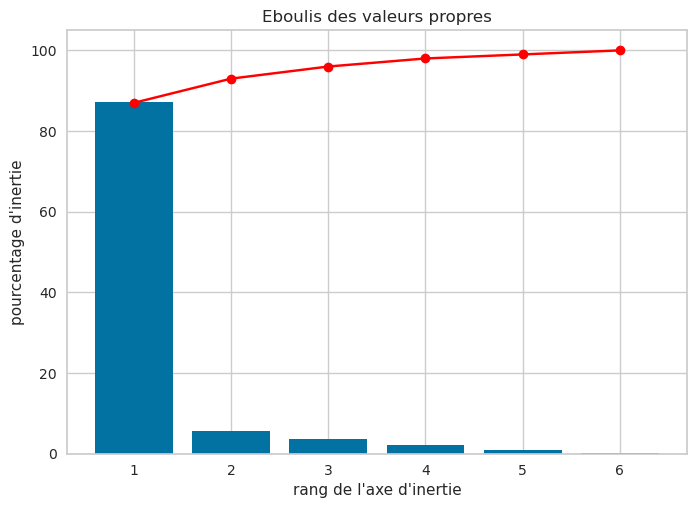

In [9]:
pca = c_PCA(df, columns,6)
pca.scale(StandardScaler())
pca.pca_evr()

Nous avons presque 100% de la variance expliquée par les 4 premiers axes. Nous allons donc nous contenter de les utiliser pour la suite de l'analyse.
On ne peut négliger le fait que 80% de la variance soit éxpliqué par le premier axe.

### Cercles Correlations

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

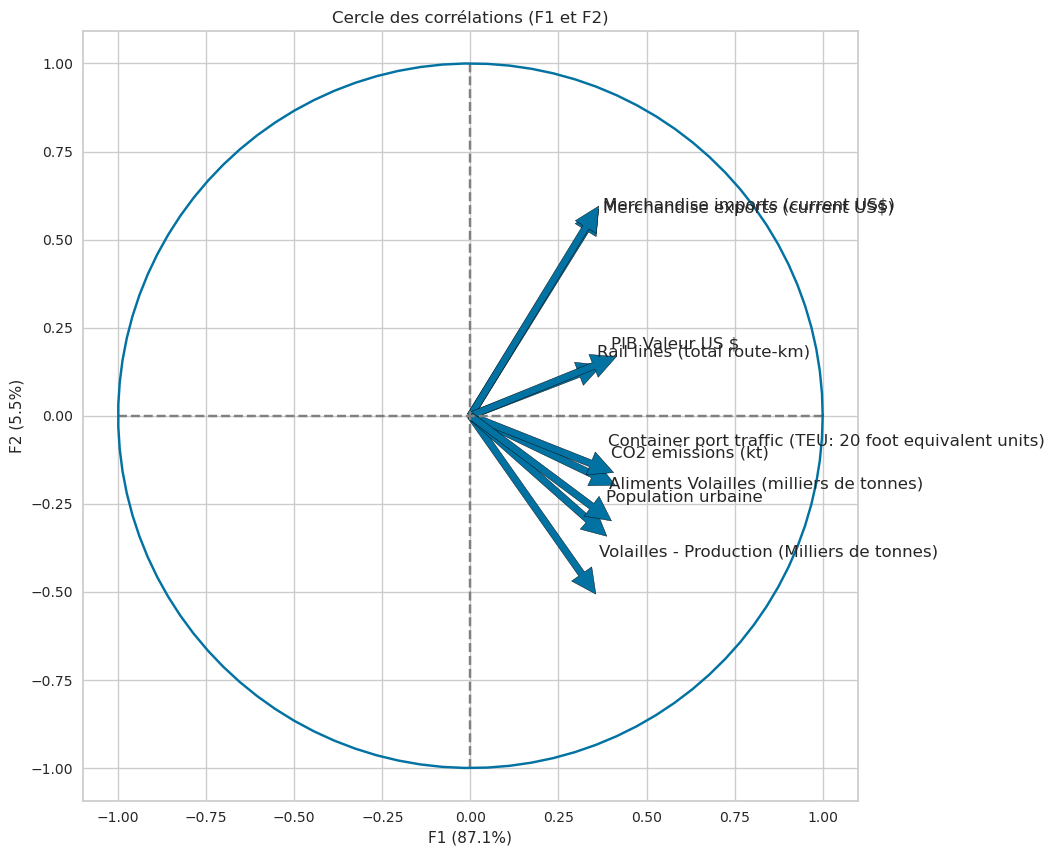

In [10]:
corr1, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (0,1))

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

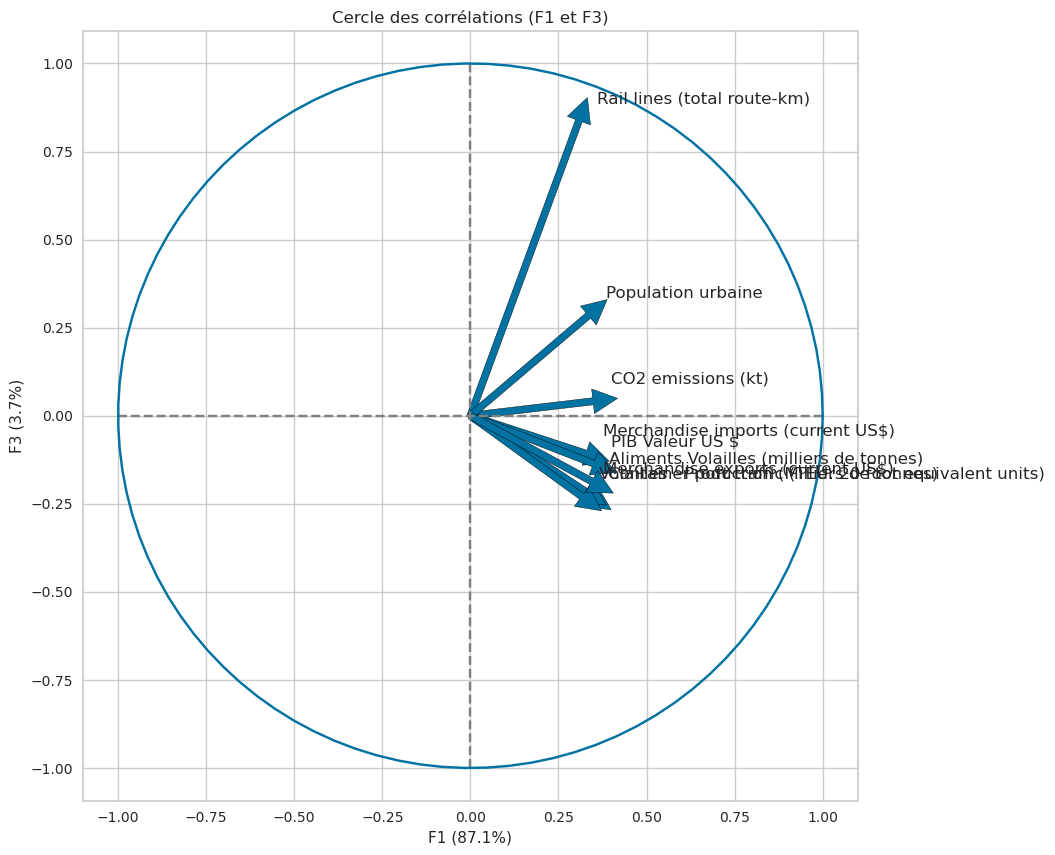

In [11]:
corr2, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (0,2))

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

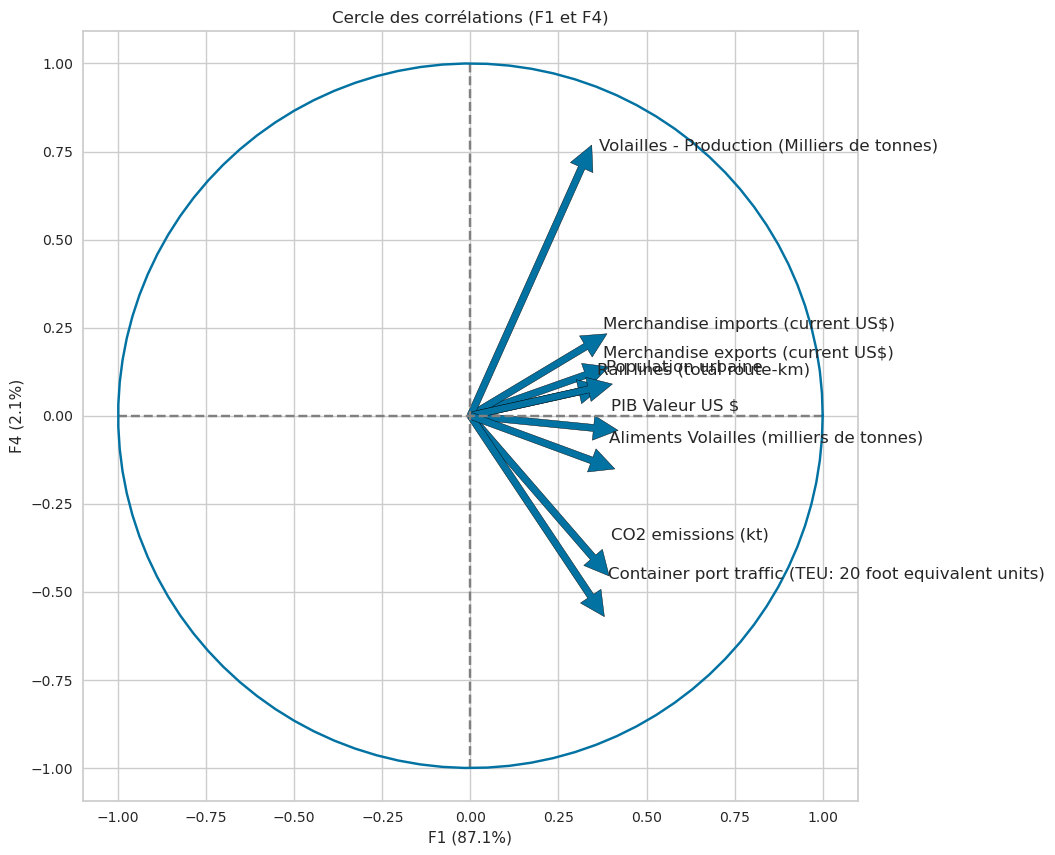

In [12]:
corr3, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (0,3))

Les variables ne se départagent pas sur F1, ce qui nous empêche de bien pouvoir l'intérpréter correctement.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

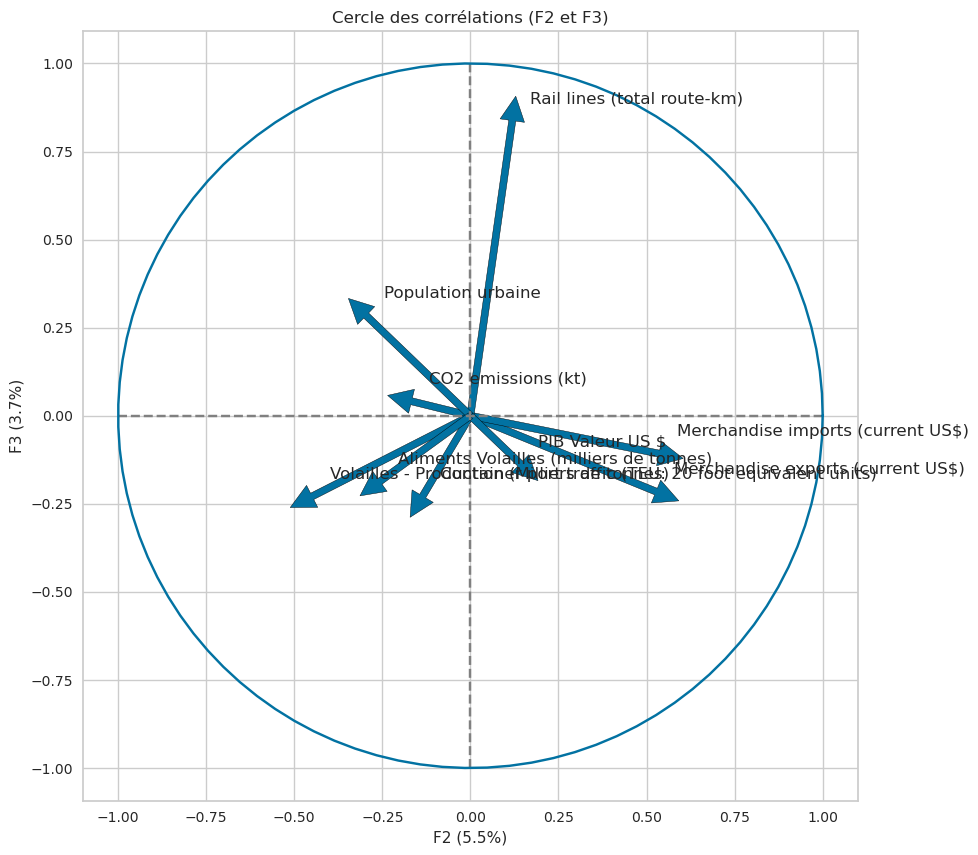

In [13]:
corr4, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (1,2))

F3 est très fortement corrélé au réseau féroviaire. Sur F2, on peut remarquer les variables d'import/export d'un côté (~0.5) et mes variables ed production de volaiile de l'autre (~0.5).

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

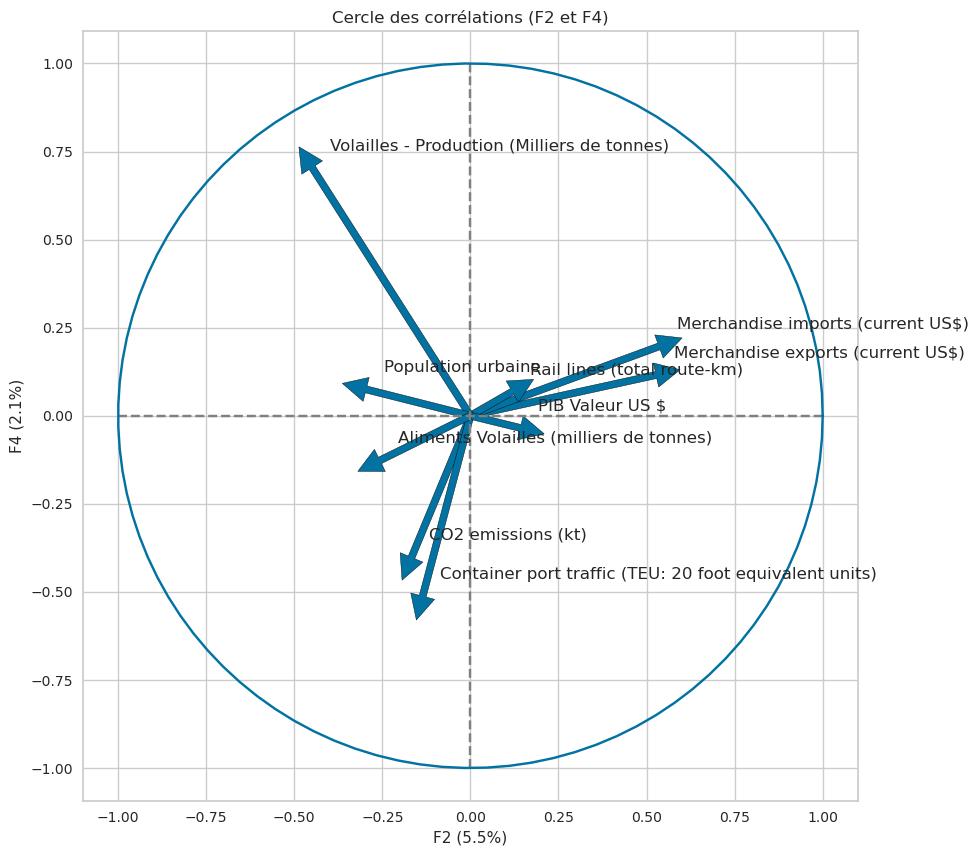

In [14]:
corr5, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (1,3))

Sur F4, nous remarquons un lien fort avec la production de volaille. On y remarque aussi un lien avec le transport maritime et les emission de CO2

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

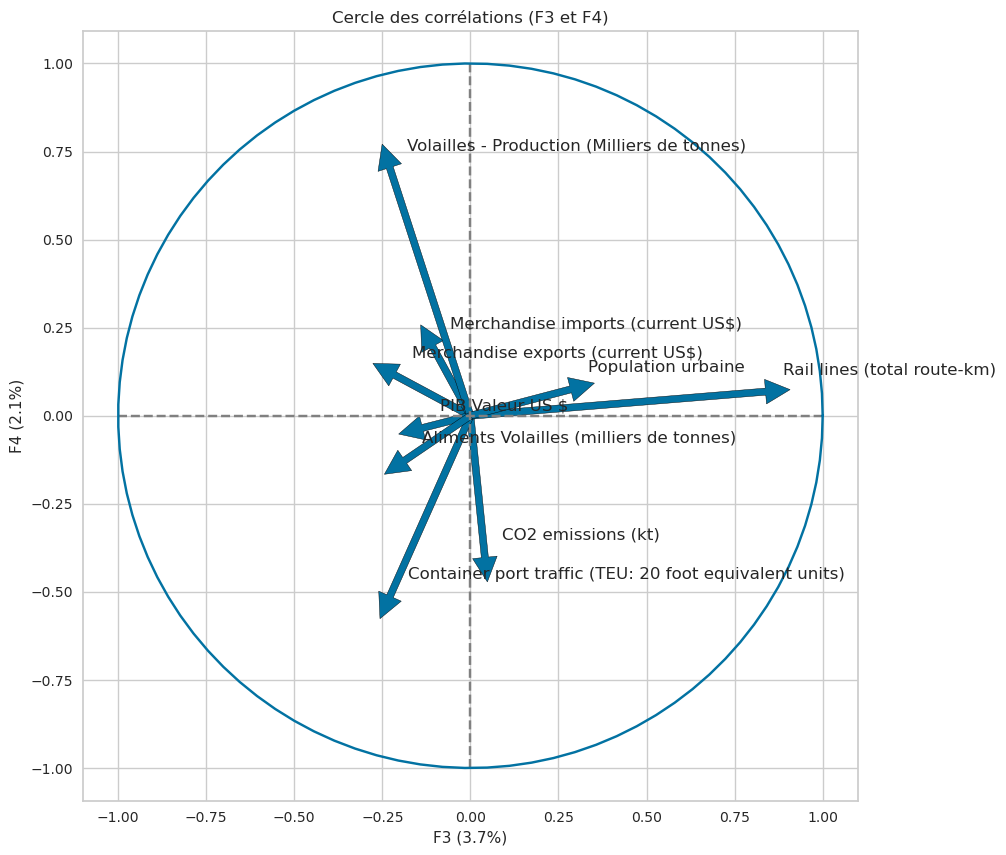

In [15]:
corr6, ax = plt.subplots(figsize=(10, 10))
pca.correlation_circle(ax, (2,3))

### Projection des individus

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

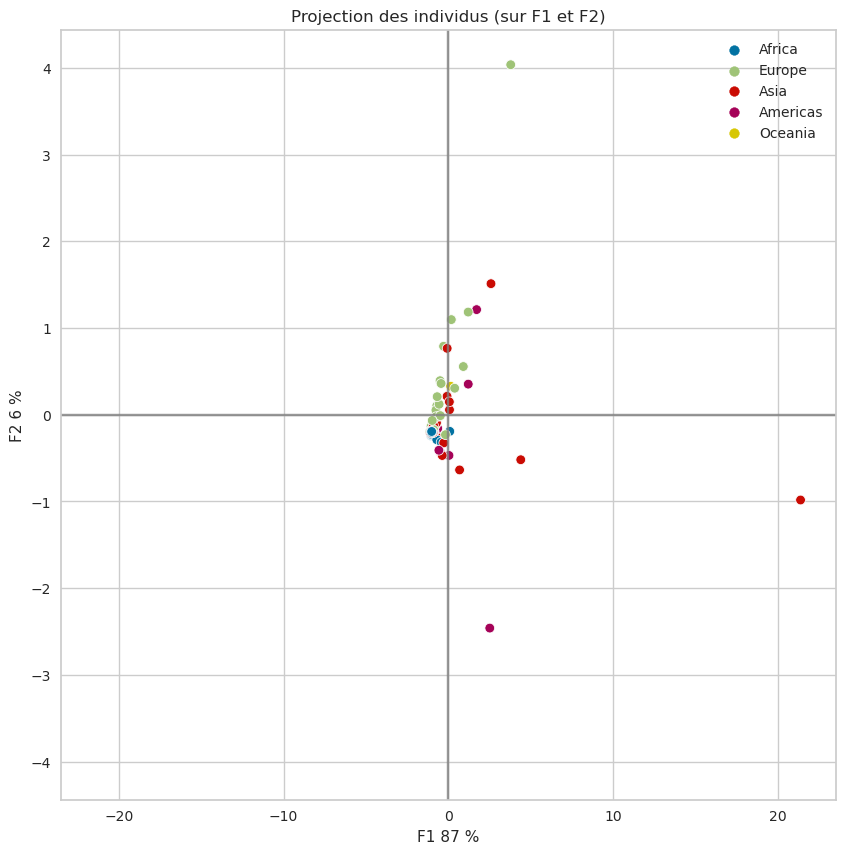

In [16]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,1), clusters=region)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

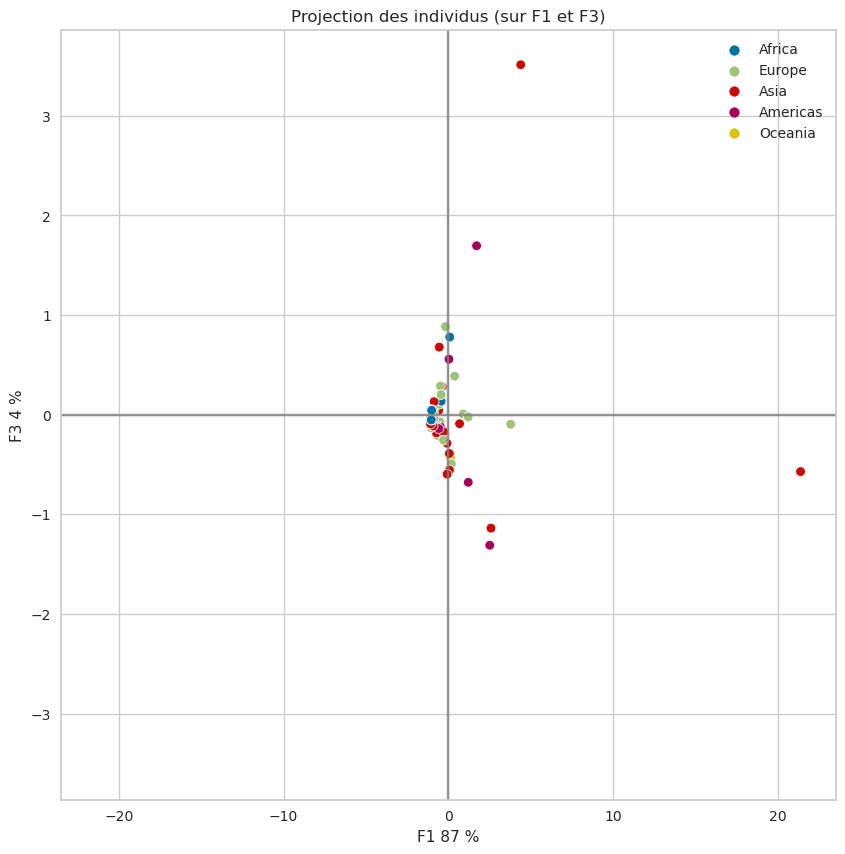

In [17]:
fp2, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,2),clusters=region)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

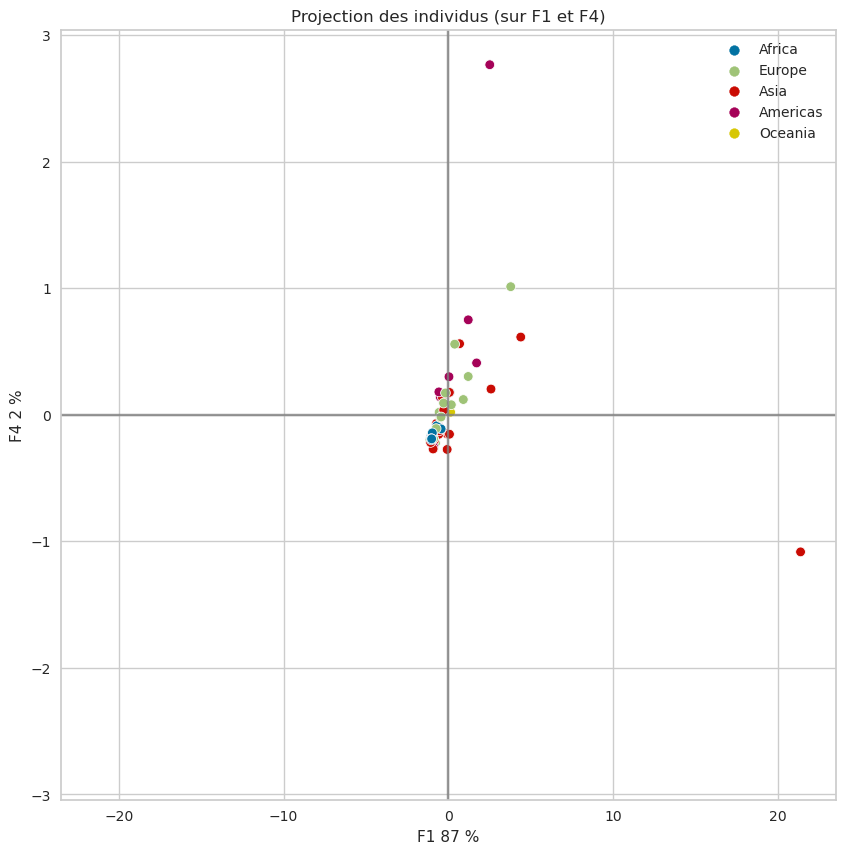

In [18]:
fp3, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,3),clusters=region)

Les variables sur F1 sont très proches les unes des autres. Il y a peu de variance sur cette dimension.

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

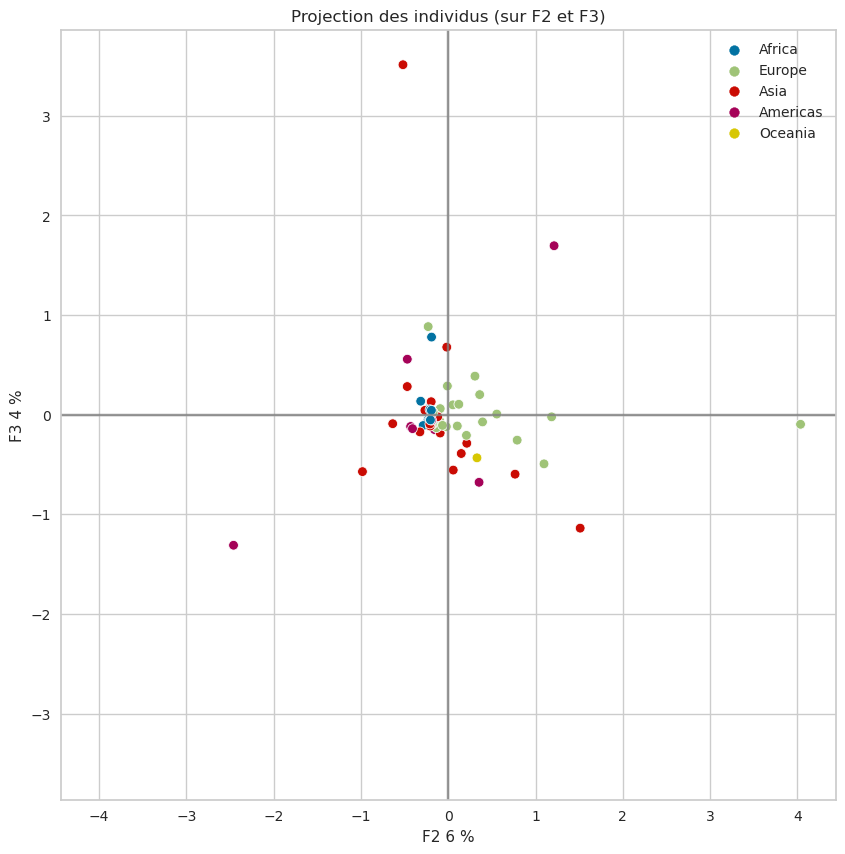

In [19]:
fp4, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(1,2),clusters=region)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

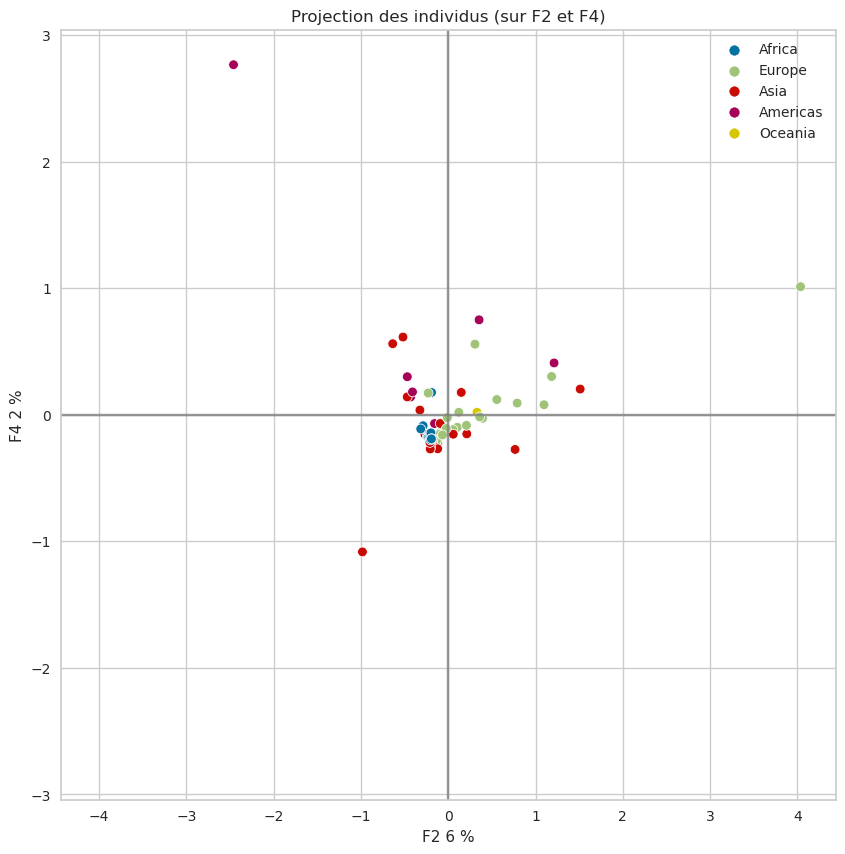

In [20]:
fp5, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(1,3),clusters=region)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

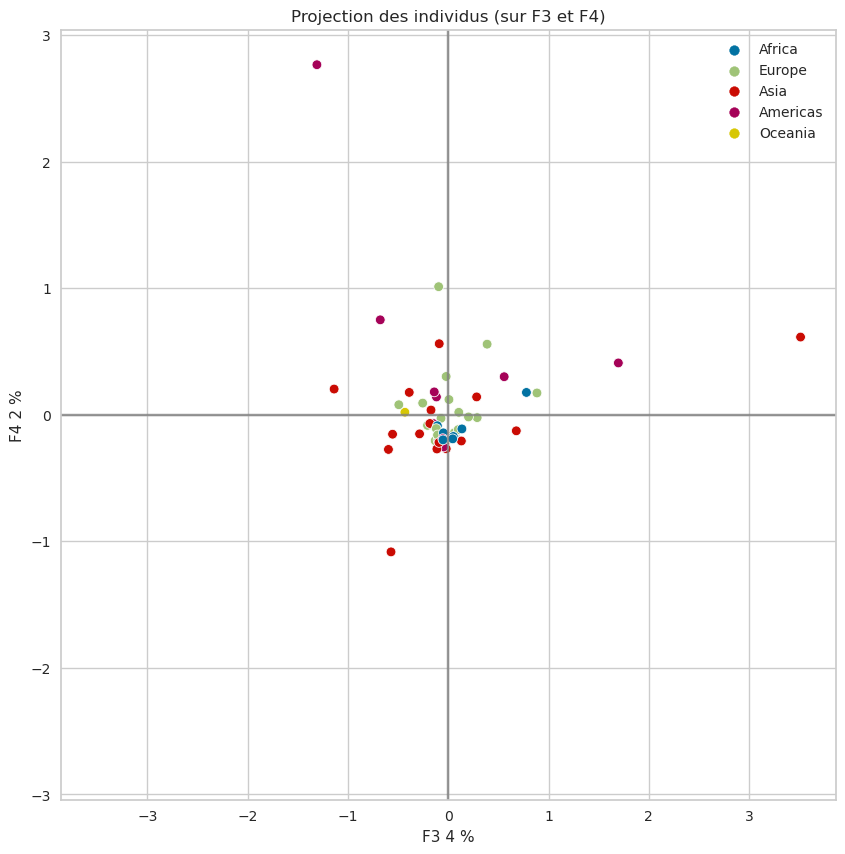

In [21]:
fp6, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(2,3),clusters=region)

Il y a bien plus de disparité sur les autres dimensions. Mais elles ne représentent qu'envion 20% de la variance. Tel quel, les données sont difficiles à interpréter

## CAH

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

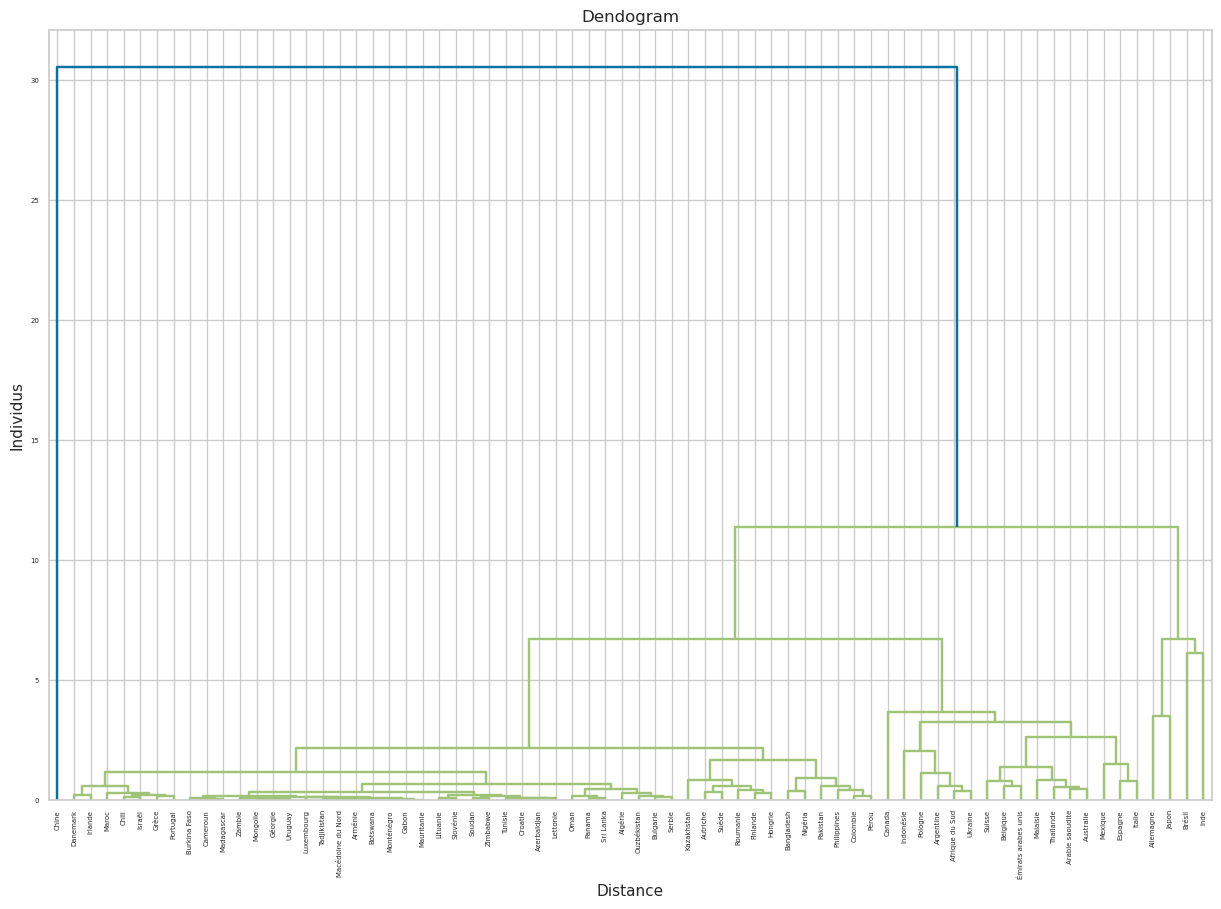

In [22]:
cah = CAH(df, columns)
cah.scale(StandardScaler())
fig, ax = plt.subplots(figsize=(15, 10))
cah.dendrogram(ax)

Nous remarquons ici que la chine occupe à elle seule un cluster. Cela peut s'expliquer par le fait que la Chine est un pays très peuplé et est, en 2019, le deuxième plus gros producteur de poulet au monde.

In [23]:
df2 = df[~df.index.str.contains(r'Chine')]

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

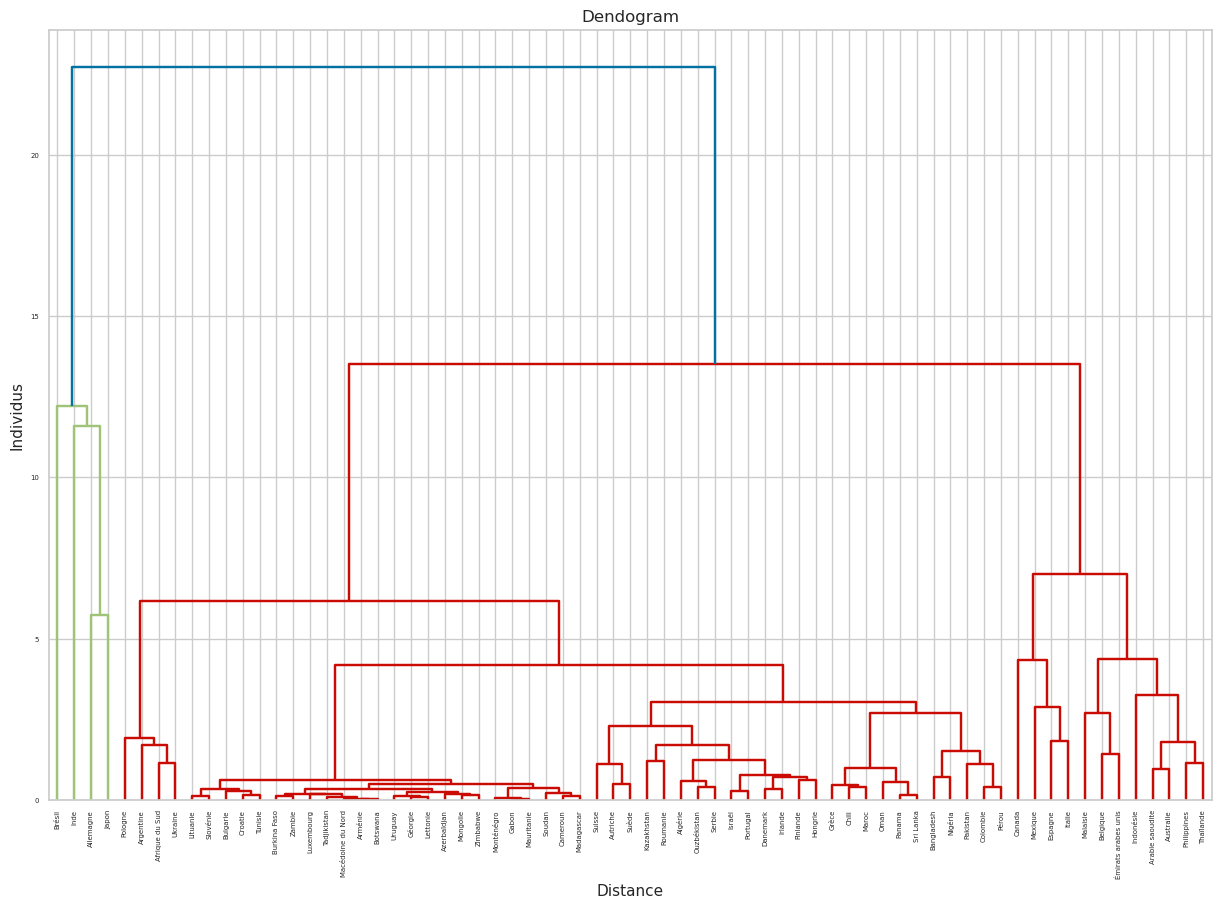

In [24]:
cah2 = CAH(df2, columns)
cah2.scale(StandardScaler())
fig, ax = plt.subplots(figsize=(15, 10))
cah2.dendrogram(ax)

Nous retrouvons ici un petit cluster composé du Japon de l'Allemagne, de l'Inde et du Brésil.
L'Inde est, au même titre que la Chine, un pays très peuplé. Le Brésil quant à lui est en 2019 le troisième plus gros producteur de poulet.
Il est plus difficile de trouver une explication pour le Japon est l'Allemagne : Etudions ces deux pays en les comparant aux autres.

In [25]:
df_jap_ger =  df.copy()
df_jap_ger['Japon/Allemagne'] = df.index.str.contains(r'Japon|Allemagne|Brésil')
df_jap_ger[df_jap_ger['Japon/Allemagne'] == True]

CO2 emissions (kt)  \
Zone                            
Allemagne            658693.5   
Brésil               434318.0   
Japon               1073645.3   

           Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                
Allemagne                                         15029605.0        
Brésil                                            10704669.0        
Japon                                             23276482.0        

           Merchandise exports (current US$)  \
Zone                                           
Allemagne                      1489412000000   
Brésil                          221127000000   
Japon                           705564000000   

           Merchandise imports (current US$)  Rail lines (total route-km)  \
Zone                                                                        
Allemagne                      1233978000000                      33423.0   
Brésil                          193162000000                       2977.5   
Japon                           720957000000                       2977.5   

           PIB Valeur US $  Volailles - Production (Milliers de tonnes)  \
Zone                                                                      
Allemagne     3.888327e+06                                       1544.0   
Brésil        1.886015e+06                                      14094.0   
Japon         5.148782e+06                                       2298.0   

           Population urbaine  Aliments Volailles (milliers de tonnes)  \
Zone                                                                     
Allemagne           63787.507                                  12920.0   
Brésil             184407.548                                  47668.0   
Japon              116322.813                                  13040.0   

           Japon/Allemagne  
Zone                        
Allemagne             True  
Brésil                True  
Japon                 True

Text(0.5, 0.98, 'Boxplot by Japon/Allemagne/ for each features')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

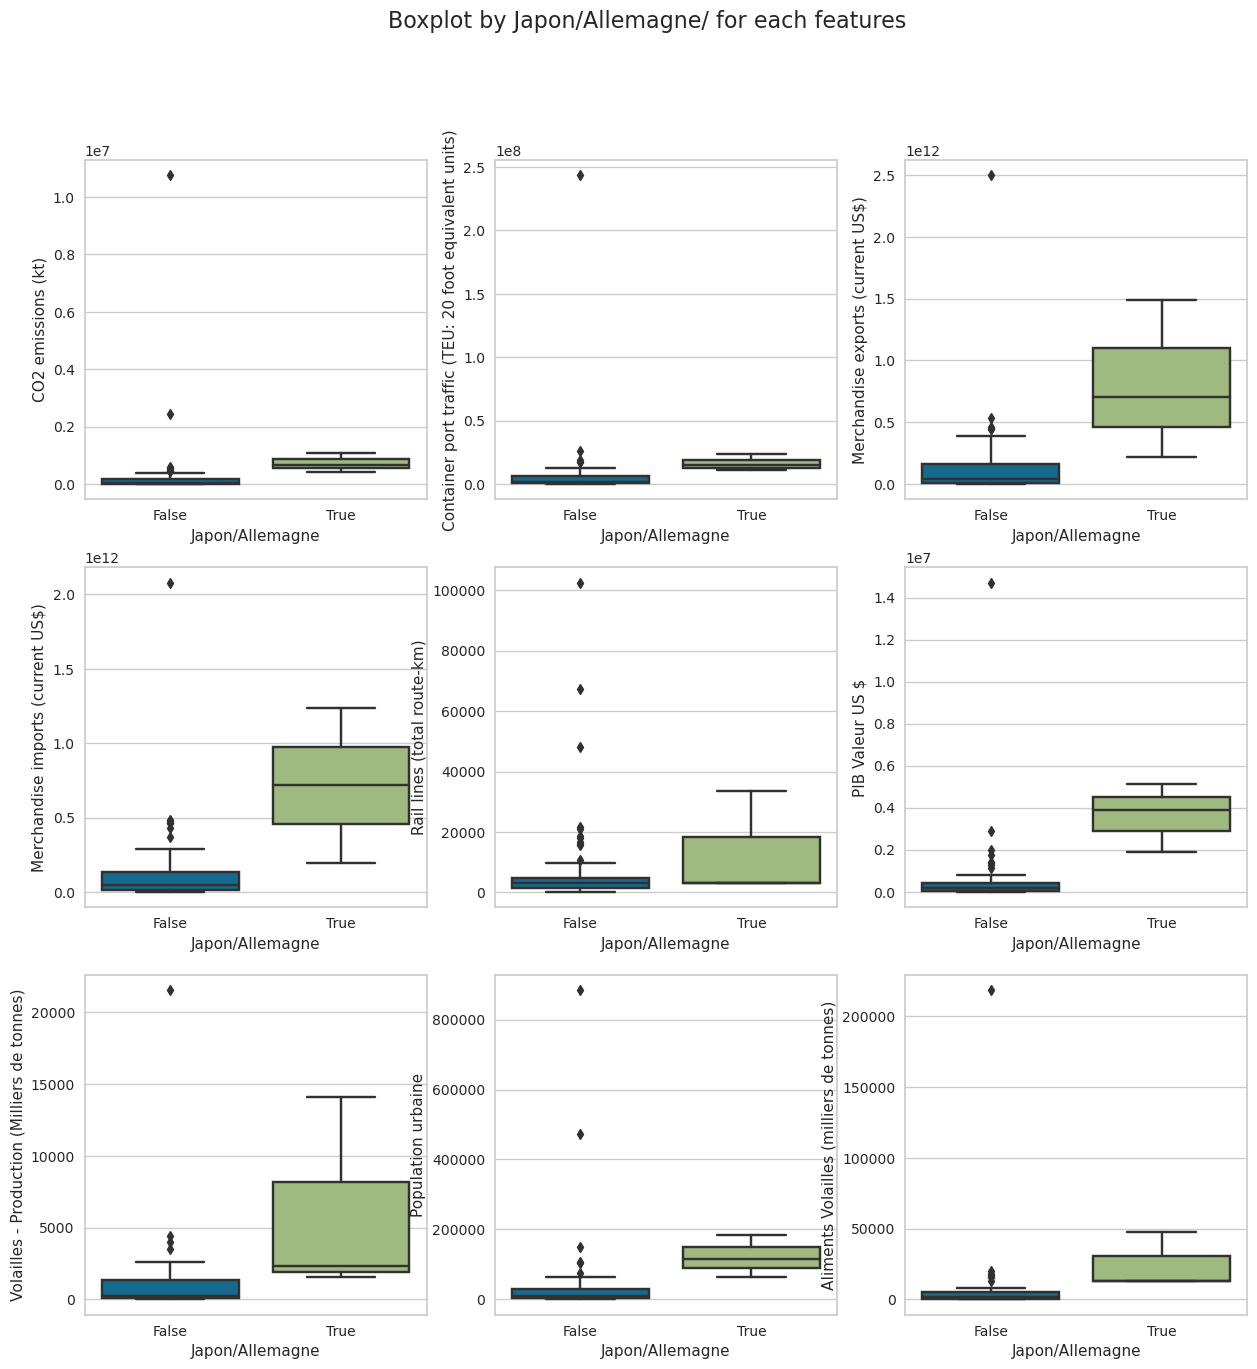

In [26]:
fig, ax = plt.subplots(3,3,figsize=(15, 15))
sns.boxplot(x="Japon/Allemagne", y="CO2 emissions (kt)", data=df_jap_ger, ax=ax[0,0])
sns.boxplot(x="Japon/Allemagne", y="Container port traffic (TEU: 20 foot equivalent units)", data=df_jap_ger, ax=ax[0,1])
sns.boxplot(x="Japon/Allemagne", y="Merchandise exports (current US$)", data=df_jap_ger, ax=ax[0,2])
sns.boxplot(x="Japon/Allemagne", y="Merchandise imports (current US$)", data=df_jap_ger, ax=ax[1,0])
sns.boxplot(x="Japon/Allemagne", y="Rail lines (total route-km)", data=df_jap_ger, ax=ax[1,1])
sns.boxplot(x="Japon/Allemagne", y="PIB Valeur US $", data=df_jap_ger, ax=ax[1,2])
sns.boxplot(x="Japon/Allemagne", y="Volailles - Production (Milliers de tonnes)", data=df_jap_ger, ax=ax[2,0])
sns.boxplot(x="Japon/Allemagne", y="Population urbaine", data=df_jap_ger, ax=ax[2,1])
sns.boxplot(x="Japon/Allemagne", y="Aliments Volailles (milliers de tonnes)", data=df_jap_ger, ax=ax[2,2])
fig.suptitle('Boxplot by Japon/Allemagne/ for each features', fontsize=16)

Nous pouvons remarquer que le Japon et L'Allemagne sont dans bien des cas dans la zone des outliers. Nous allons donc les retirer de l'analyse. Ils nécessiteraient une analyse à eux seul.

## Kmeans

Pour le K-means, nous allons simplement étudier le résultat sans le retrait du Japon, de l'Allemagne, de la Chine, de l'Inde et du Brésil. Nous relancerons une analyse ultérieurement (ACP/CAH/Kmeans) sans ces pays.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

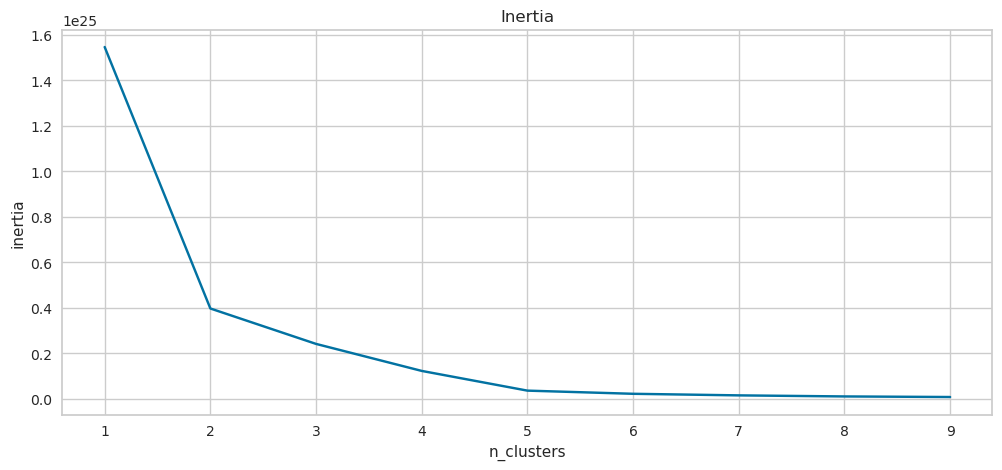

In [27]:
km = kmeans(df, columns)
fig, ax = plt.subplots(figsize=(12, 5))
km.plot_inertia(ax)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

For n_clusters = 2, silhouette score is 0.894)
For n_clusters = 3, silhouette score is 0.740)
For n_clusters = 4, silhouette score is 0.715)
For n_clusters = 5, silhouette score is 0.694)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

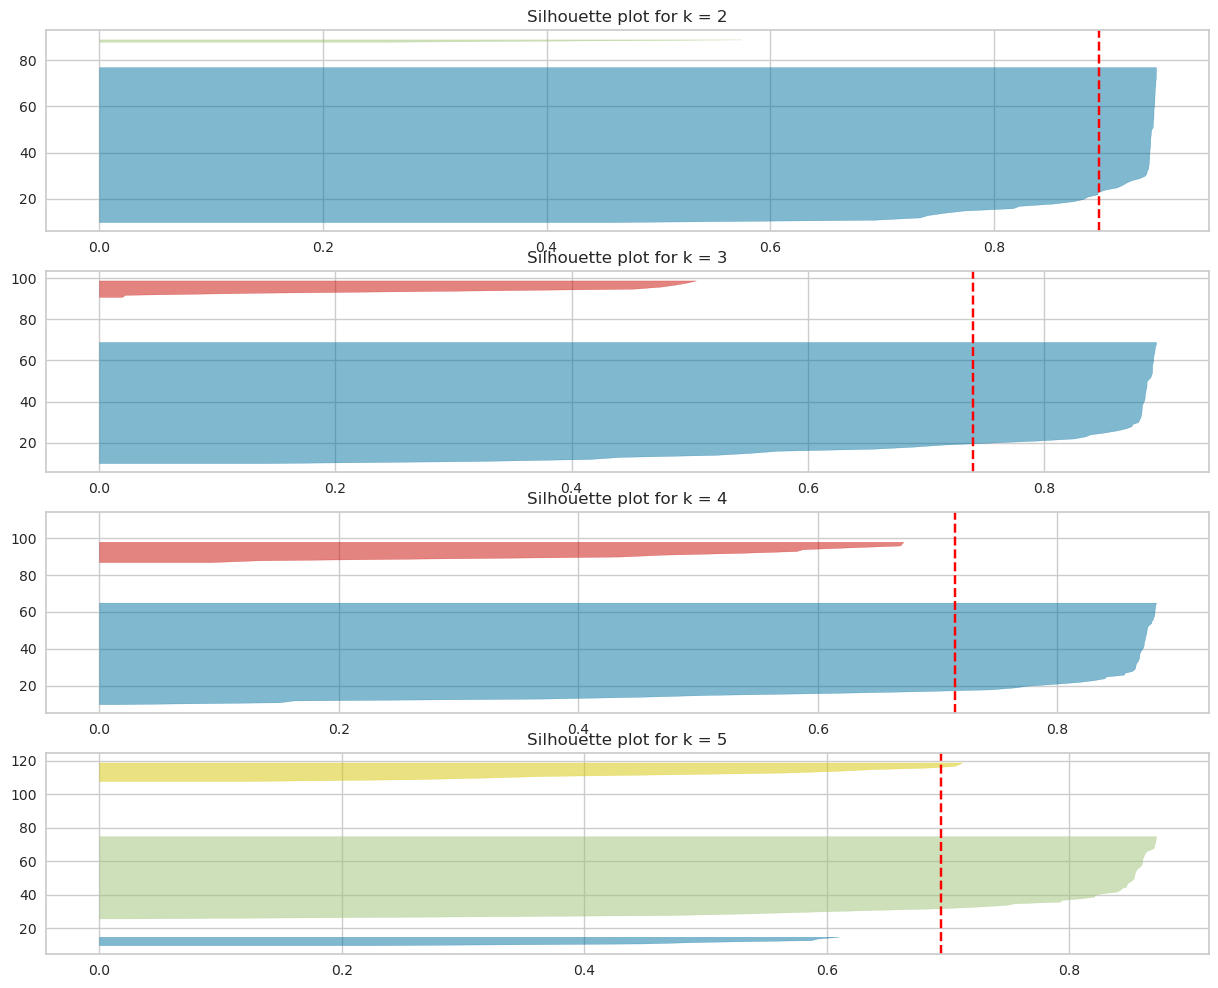

In [28]:
fig, ax = plt.subplots(4,1,figsize=(15, 12))
km.plot_silhouette(ax,[2,3,4,5])

Si l'on s'intéresse graphique de silhouette, on remarque que pour K=2 les clusters sont assez mal définit : Nous avons un énorme cluster et un autre qui est composé de très peu de pays. Nous pouvons déjà penser à des pays comme la Chine, le Brésil ou l'Inde.

In [29]:
km.kmean_choose(2)
km.clusters

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32)

In [30]:
df['cluster']=km.clusters
columns.append('cluster')

### Clusters

In [31]:
df.columns

Index(['CO2 emissions (kt)',
       'Container port traffic (TEU: 20 foot equivalent units)',
       'Merchandise exports (current US$)',
       'Merchandise imports (current US$)', 'Rail lines (total route-km)',
       'PIB Valeur US $', 'Volailles - Production (Milliers de tonnes)',
       'Population urbaine', 'Aliments Volailles (milliers de tonnes)',
       'cluster'],
      dtype='object')

In [32]:
km_df = df[columns]

Text(0.5, 0.98, 'Boxplot by clusters for each features')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

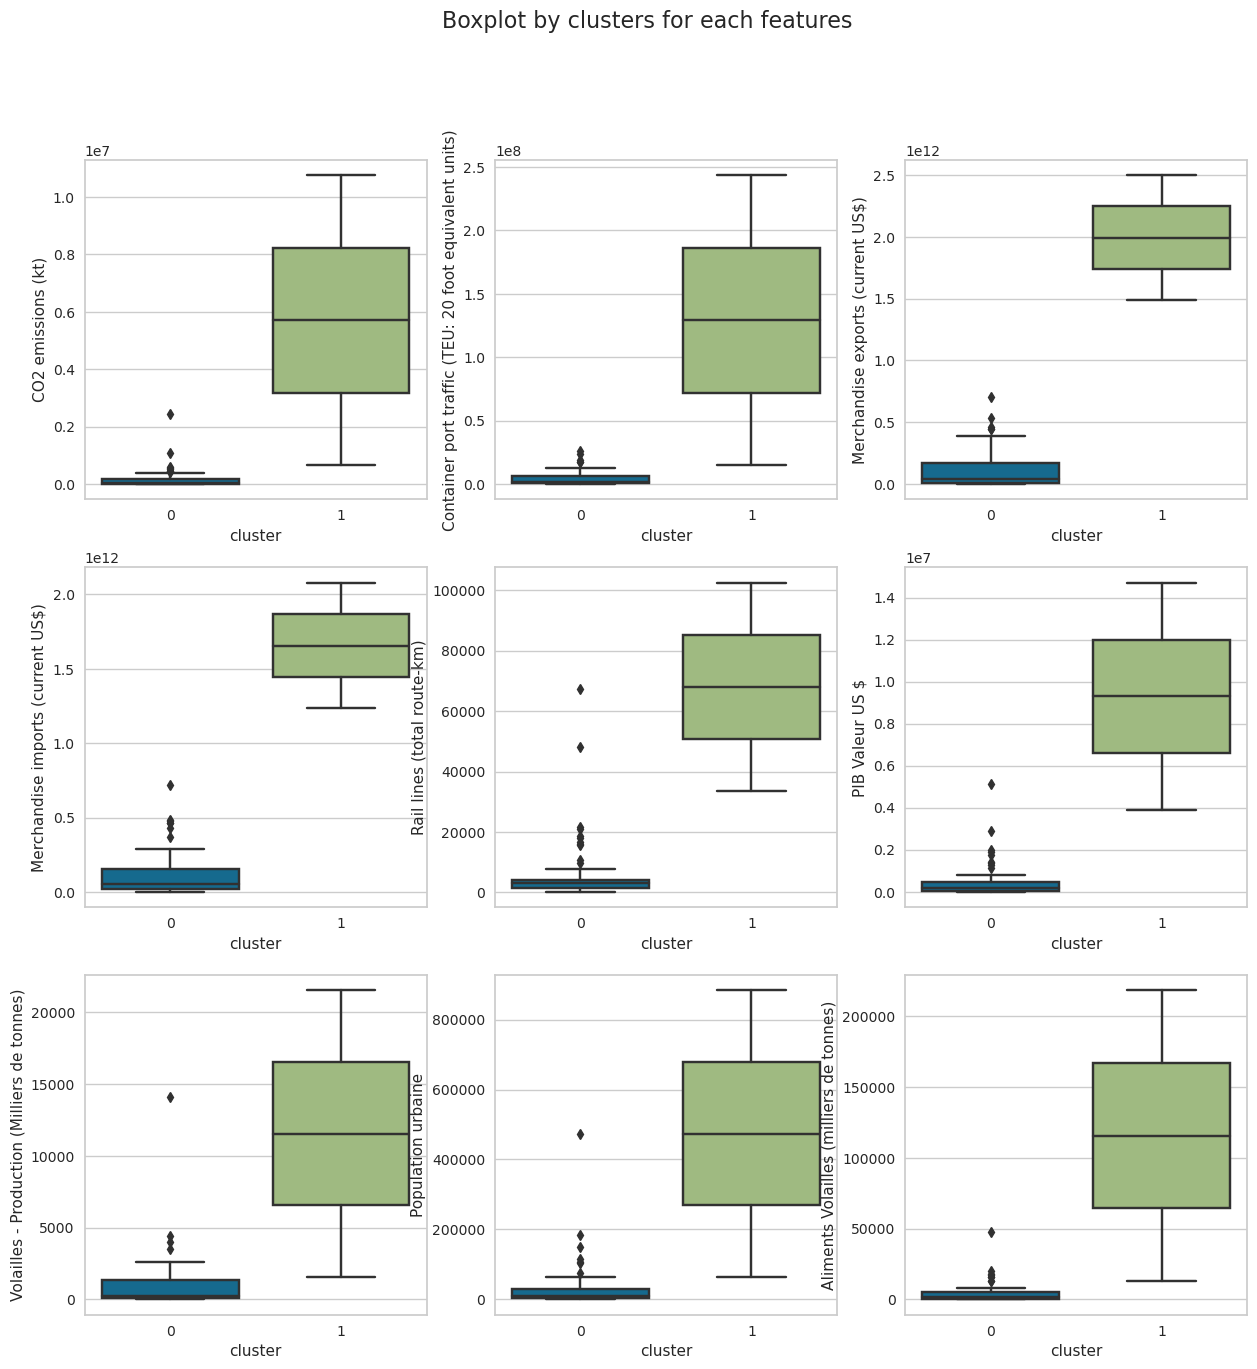

In [33]:
# box plot by clusters for each feature
fig, ax = plt.subplots(3,3,figsize=(15, 15))
sns.boxplot(x="cluster", y="CO2 emissions (kt)", data=km_df, ax=ax[0,0])
sns.boxplot(x="cluster", y="Container port traffic (TEU: 20 foot equivalent units)", data=km_df, ax=ax[0,1])
sns.boxplot(x="cluster", y="Merchandise exports (current US$)", data=km_df, ax=ax[0,2])
sns.boxplot(x="cluster", y="Merchandise imports (current US$)", data=km_df, ax=ax[1,0])
sns.boxplot(x="cluster", y="Rail lines (total route-km)", data=km_df, ax=ax[1,1])
sns.boxplot(x="cluster", y="PIB Valeur US $", data=km_df, ax=ax[1,2])
sns.boxplot(x="cluster", y="Volailles - Production (Milliers de tonnes)", data=km_df, ax=ax[2,0])
sns.boxplot(x="cluster", y="Population urbaine", data=km_df, ax=ax[2,1])
sns.boxplot(x="cluster", y="Aliments Volailles (milliers de tonnes)", data=km_df, ax=ax[2,2])
fig.suptitle('Boxplot by clusters for each features', fontsize=16)

In [34]:
cluster0 = km_df[km_df['cluster']==0]
cluster0

CO2 emissions (kt)  \
Zone                                      
Afrique du Sud                 446626.0   
Algérie                        170582.4   
Arabie saoudite                526770.3   
Argentine                      168162.0   
Arménie                          6195.6   
...                                 ...   
Ukraine                        174599.9   
Uruguay                          6806.7   
Zambie                           7615.7   
Zimbabwe                        10185.3   
Émirats arabes unis            185645.7   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Afrique du Sud                                               4529034.0        
Algérie                                                      1793990.0        
Arabie saoudite                                              8905621.0        
Argentine                                                    1833964.0        
Arménie                                                      1229081.0        
...                                                                ...        
Ukraine                                                      1007273.0        
Uruguay                                                       749562.0        
Zambie                                                       1229081.0        
Zimbabwe                                                     1229081.0        
Émirats arabes unis                                         18802000.0        

                     Merchandise exports (current US$)  \
Zone                                                     
Afrique du Sud                             90016000000   
Algérie                                    35312000000   
Arabie saoudite                           261603000000   
Argentine                                  65116000000   
Arménie                                     2640000000   
...                                                ...   
Ukraine                                    50054000000   
Uruguay                                     7680000000   
Zambie                                      7039000000   
Zimbabwe                                    4269000000   
Émirats arabes unis                       389428000000   

                     Merchandise imports (current US$)  \
Zone                                                     
Afrique du Sud                            107539000000   
Algérie                                    44632000000   
Arabie saoudite                           153163000000   
Argentine                                  49124000000   
Arménie                                     5514000000   
...                                                ...   
Ukraine                                    60800000000   
Uruguay                                     8246000000   
Zambie                                      7173000000   
Zimbabwe                                    4817000000   
Émirats arabes unis                       288447000000   

                     Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                                
Afrique du Sud                          20953.00    351430.991183   
Algérie                                  4020.25    171158.234285   
Arabie saoudite                          2977.50    792966.838190   
Argentine                               17866.00    445445.254556   
Arménie                                   698.40     13619.290546   
...                                          ...              ...   
Ukraine                                 21625.90    153929.552493   
Uruguay                                  1498.00     61231.193299   
Zambie                                   1248.00     23309.720448   
Zimbabwe                                 3120.00     21935.075306   
Émirats arabes unis                       261.00    417215.559513   

                     Vola

In [35]:
cluster1 = km_df[km_df['cluster']==1]
cluster1

CO2 emissions (kt)  \
Zone                            
Allemagne            658693.5   
Chine              10762824.0   

           Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                
Allemagne                                         15029605.0        
Chine                                            243560000.0        

           Merchandise exports (current US$)  \
Zone                                           
Allemagne                      1489412000000   
Chine                          2499457000000   

           Merchandise imports (current US$)  Rail lines (total route-km)  \
Zone                                                                        
Allemagne                      1233978000000                      33423.0   
Chine                          2078386000000                     102462.0   

           PIB Valeur US $  Volailles - Production (Milliers de tonnes)  \
Zone                                                                      
Allemagne     3.888327e+06                                       1544.0   
Chine         1.470083e+07                                      21518.0   

           Population urbaine  Aliments Volailles (milliers de tonnes)  \
Zone                                                                     
Allemagne           63787.507                                  12920.0   
Chine              883204.937                                 218290.0   

           cluster  
Zone                
Allemagne        1  
Chine            1

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

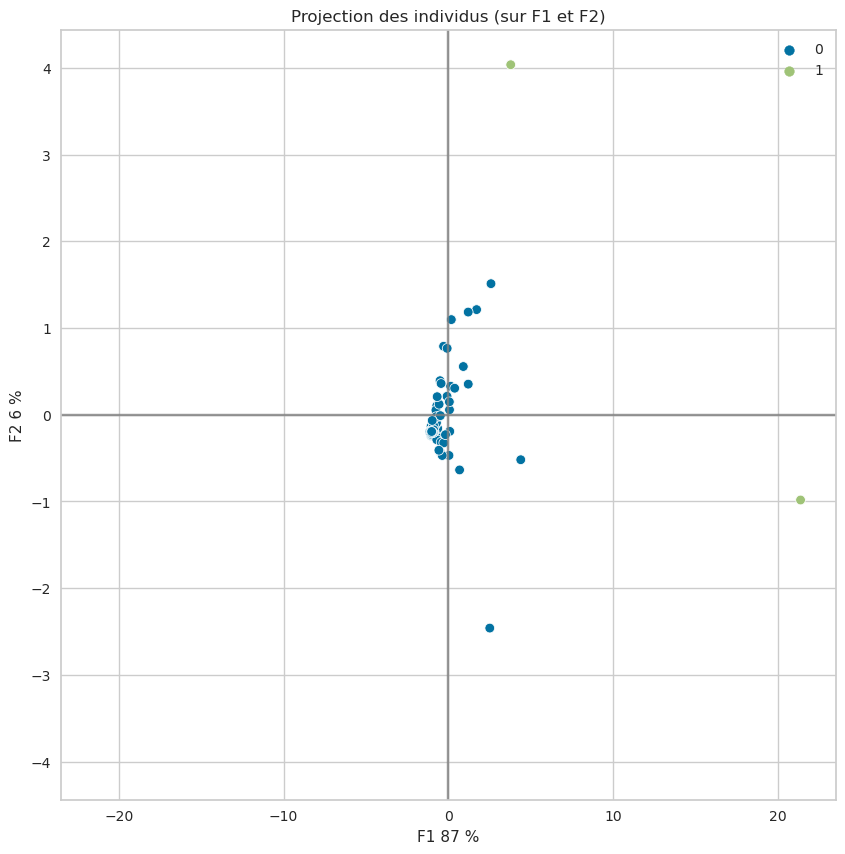

In [36]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca.display_factorial_planesi(ax,(0,1), clusters=km.clusters)

## Conclusions
Le jeu de donnée est bien trop impacté par des "poids lourds" comme la Chine. Nous allons relancer notre analyse en prenant soin de transformer nos données avec le logarithme décimal. 

# Analyse np.log

In [37]:
df = df_og.copy()

In [38]:
region = df['region'].tolist()
df = df.drop(columns=['region'])
columns = df.columns.tolist()
df.head()

CO2 emissions (kt)  \
Zone                                  
Afrique du Sud             446626.0   
Algérie                    170582.4   
Allemagne                  658693.5   
Arabie saoudite            526770.3   
Argentine                  168162.0   

                 Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                      
Afrique du Sud                                           4529034.0        
Algérie                                                  1793990.0        
Allemagne                                               15029605.0        
Arabie saoudite                                          8905621.0        
Argentine                                                1833964.0        

                 Merchandise exports (current US$)  \
Zone                                                 
Afrique du Sud                         90016000000   
Algérie                                35312000000   
Allemagne                            1489412000000   
Arabie saoudite                       261603000000   
Argentine                              65116000000   

                 Merchandise imports (current US$)  \
Zone                                                 
Afrique du Sud                        107539000000   
Algérie                                44632000000   
Allemagne                            1233978000000   
Arabie saoudite                       153163000000   
Argentine                              49124000000   

                 Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                            
Afrique du Sud                      20953.00     3.514310e+05   
Algérie                              4020.25     1.711582e+05   
Allemagne                           33423.00     3.888327e+06   
Arabie saoudite                      2977.50     7.929668e+05   
Argentine                           17866.00     4.454453e+05   

                 Volailles - Production (Milliers de tonnes)  \
Zone                                                           
Afrique du Sud                                        1816.0   
Algérie                                                285.0   
Allemagne                                             1544.0   
Arabie saoudite                                        800.0   
Argentine                                             2249.0   

                 Population urbaine  Aliments Volailles (milliers de tonnes)  
Zone                                                                          
Afrique du Sud            38820.239                                   5721.0  
Algérie                   31236.431                                   4152.0  
Allemagne                 63787.507                                  12920.0  
Arabie saoudite           28700.362                                   2511.0  
Argentine                 41489.566                                  16050.0

In [39]:
df_log = df.applymap(lambda x: np.log(x+1))
df = df_log

## PCA

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

Explained variance ratio:  [76.77  9.52  5.19  3.79  2.5   1.3 ]
Cumulative explained variance ratio:  [77. 86. 91. 95. 98. 99.]


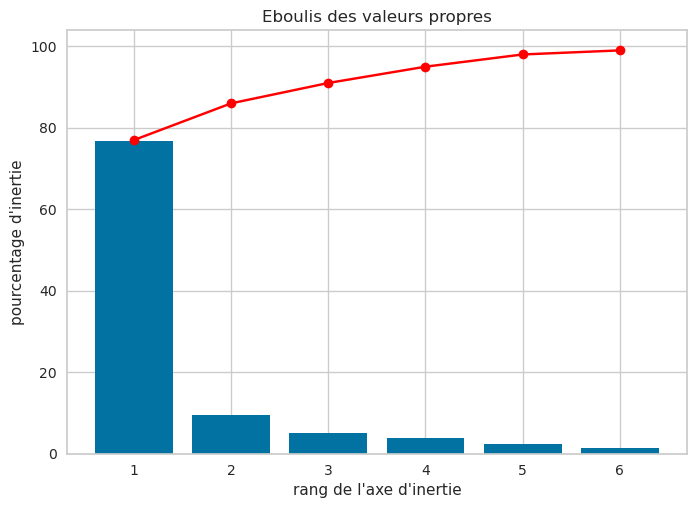

In [40]:
pca2 = c_PCA(df, columns,6)
pca2.scale(RobustScaler())
pca2.pca_evr()

Nous pouvons déjà remarquer un impact sur notre PCA. En effet, nous maintenant 60% de la variance expliquée sur l'Axe 1. Avec 4 dimensions, nous pourrons expliquer environ 90% de la variance.

### Cercles Correlations

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

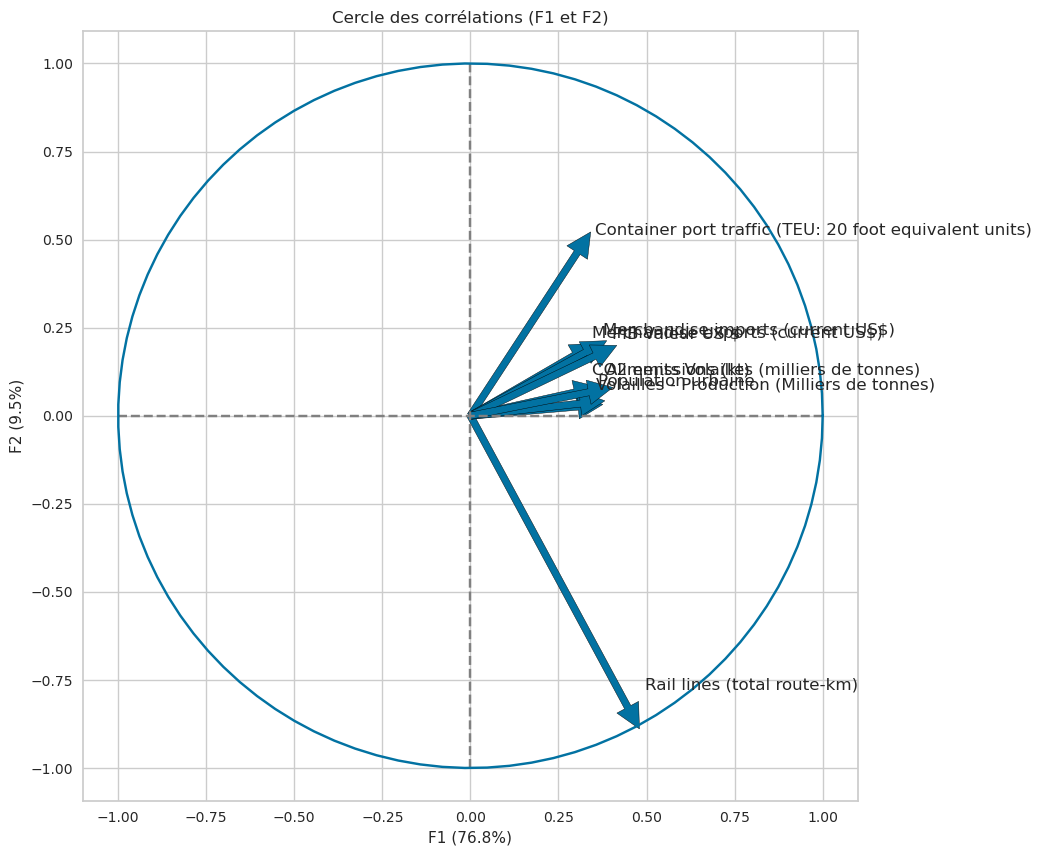

In [41]:
corr1, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (0,1))

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

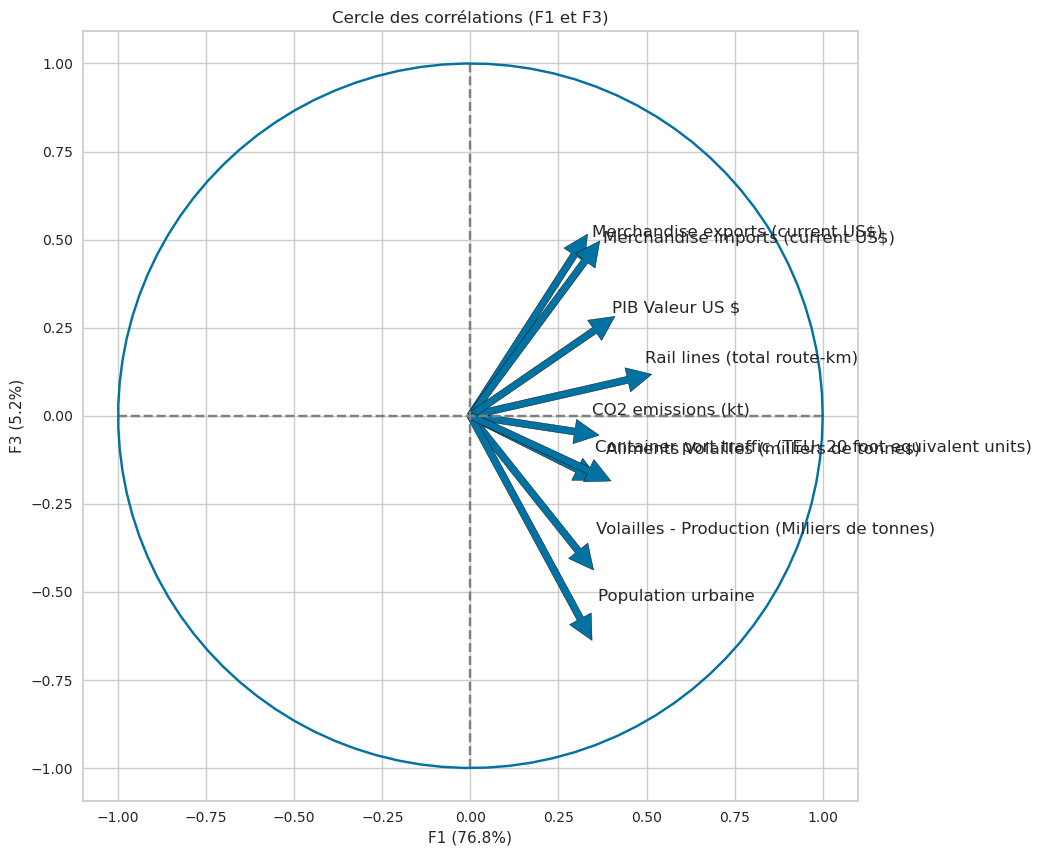

In [42]:
corr2, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (0,2))

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

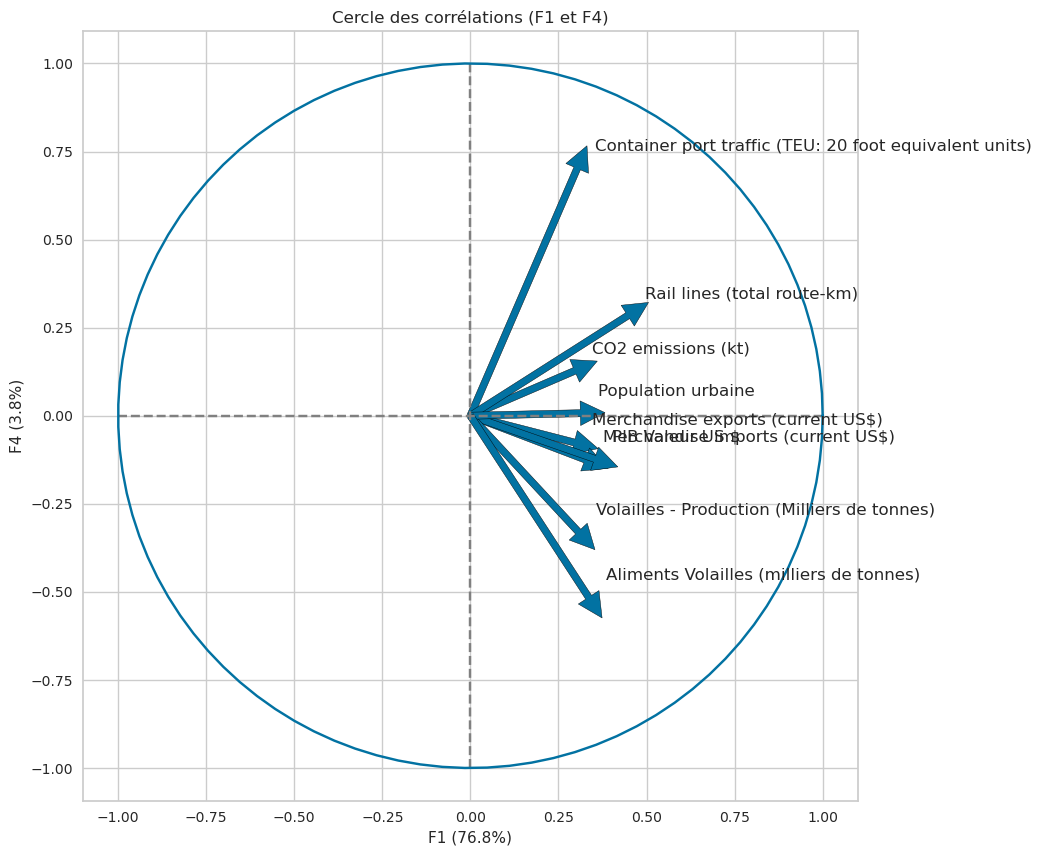

In [43]:
corr3, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (0,3))

La conclusion sur F1 est similaire à l'analyse précédente : Les variables ne se départagent pas sur F1, ce qui nous empêche de bien pouvoir l'intérpréter correctement.

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

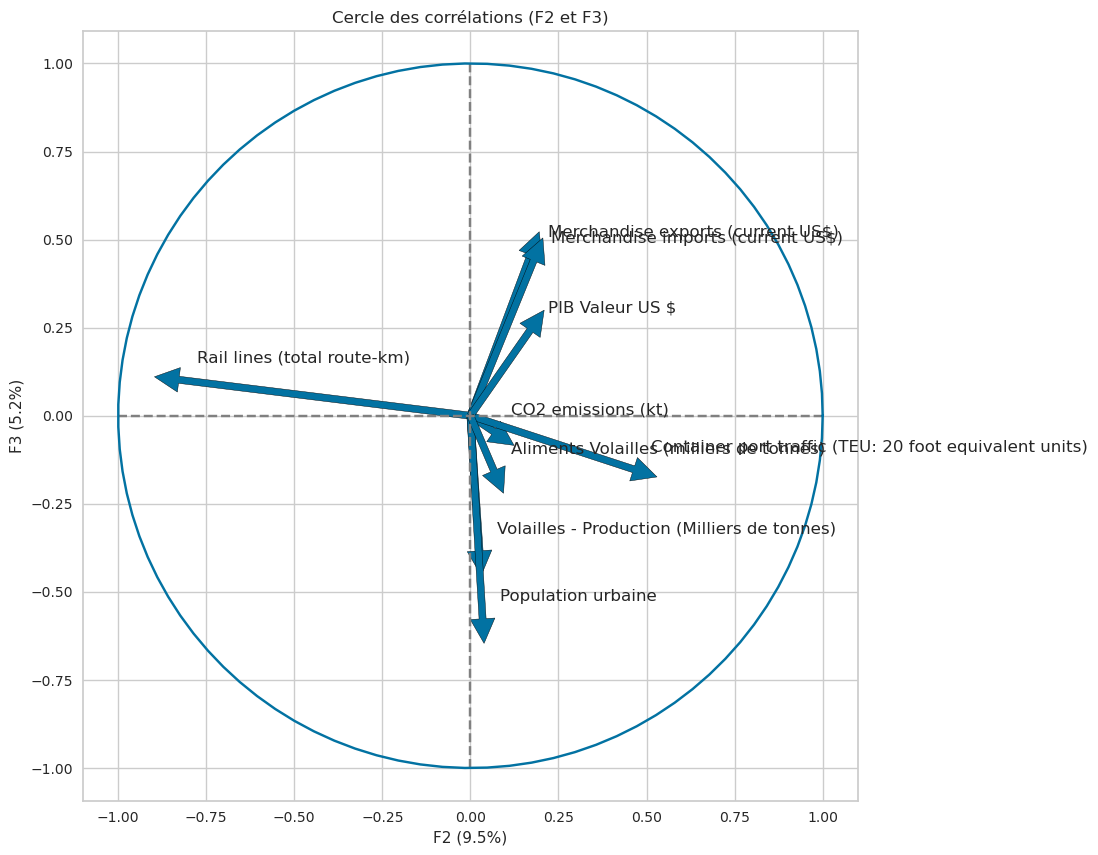

In [44]:
corr4, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (1,2))

F2 montre ici une corrélation modérée de la population urbain sur cette dimension. Nous retrouvons sur F3 notre corrélation positive sur le réseau féroviaire et notre corrélation négative sur les émissions de CO2. 

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

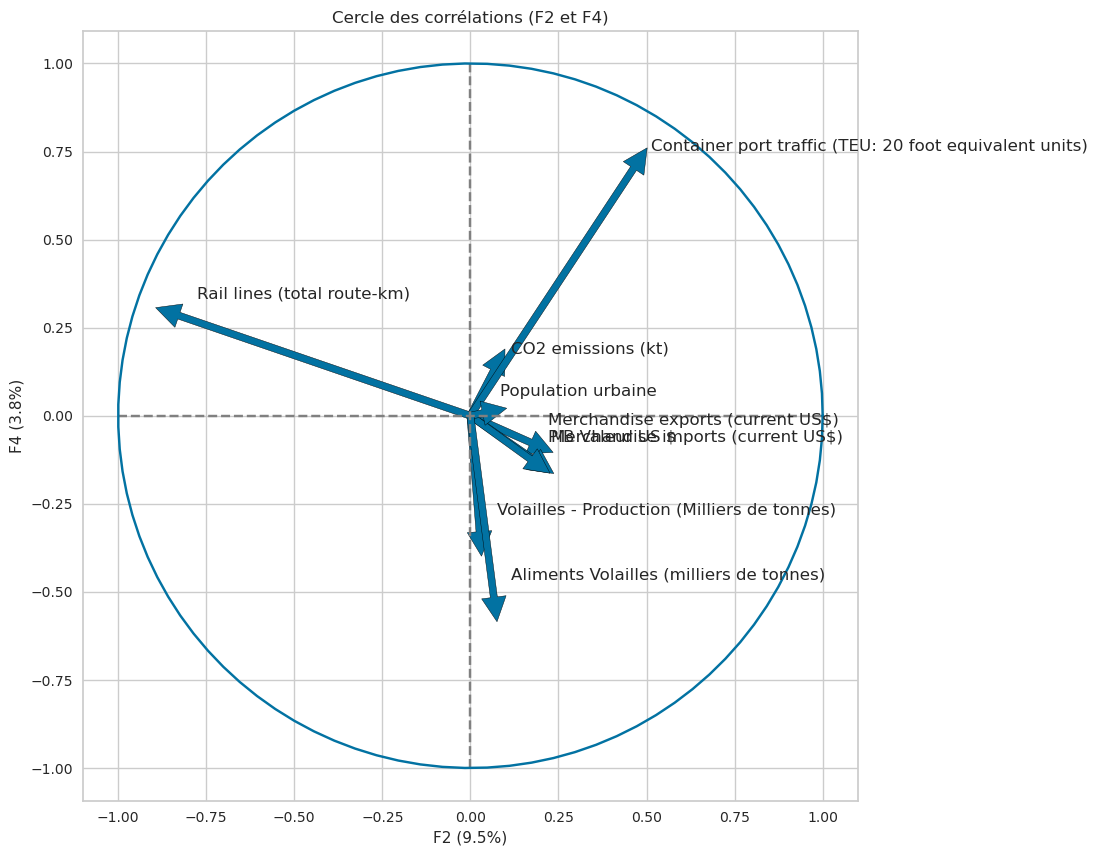

In [45]:
corr5, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (1,3))

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

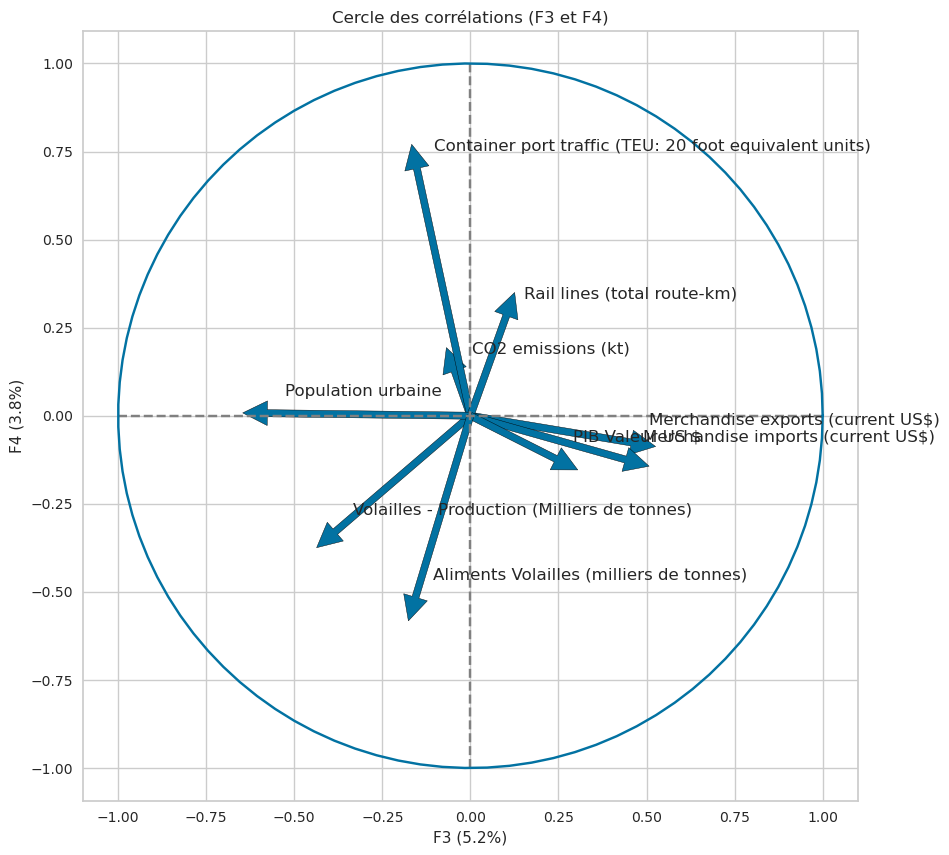

In [46]:
corr6, ax = plt.subplots(figsize=(10, 10))
pca2.correlation_circle(ax, (2,3))

### Projection des individus

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

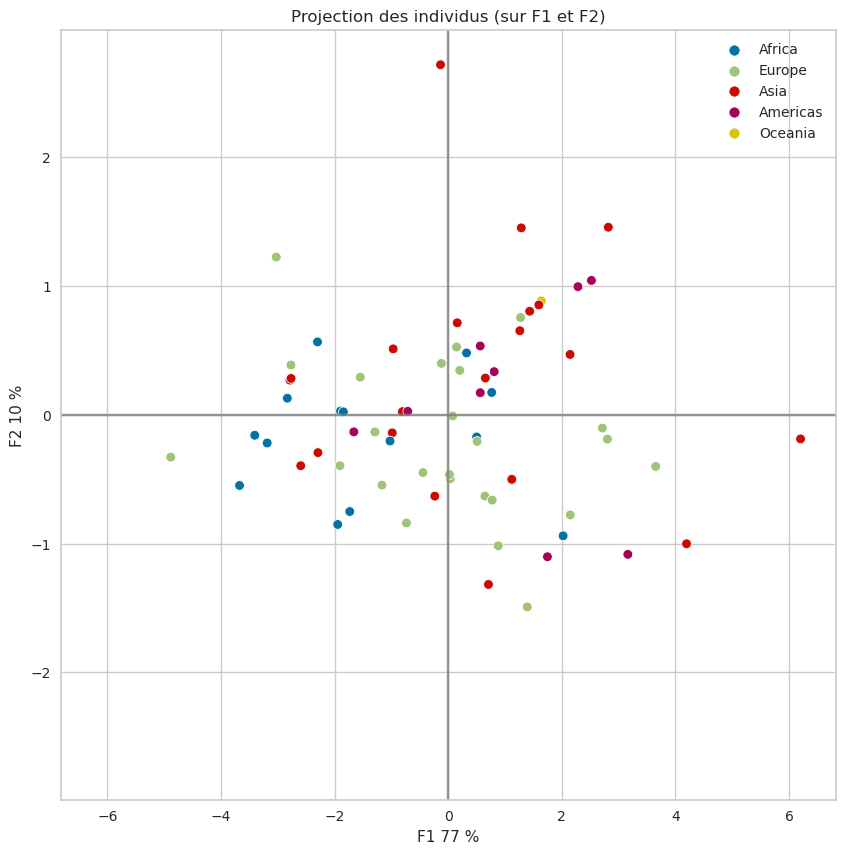

In [47]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,1), clusters=region)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

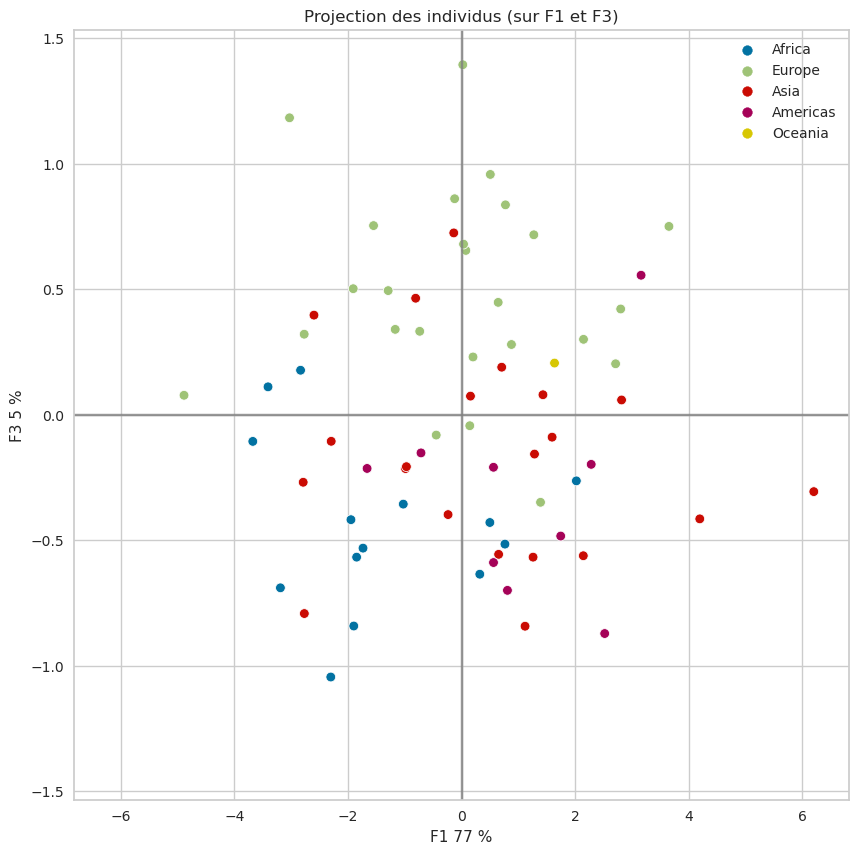

In [48]:
fp2, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,2),clusters=region)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

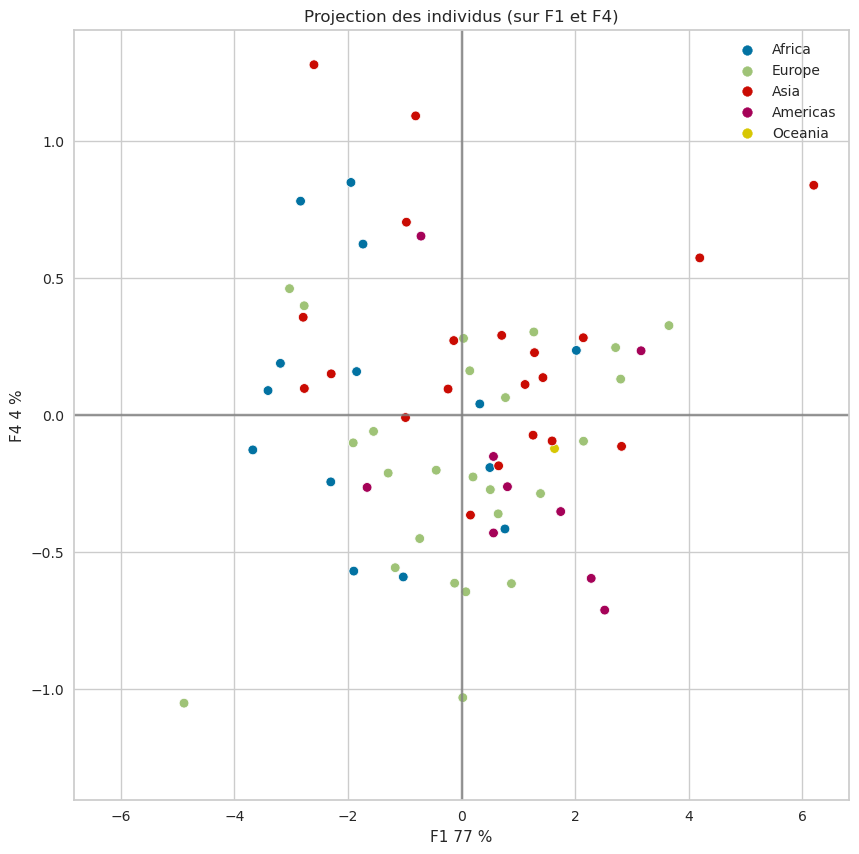

In [49]:
fp3, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,3),clusters=region)

Nous remarquons ici que les individus ne sont plus "tassés" comme lors de notre analyse précédente. Nous avons une meilleure répartition des individus sur les dimensions.

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

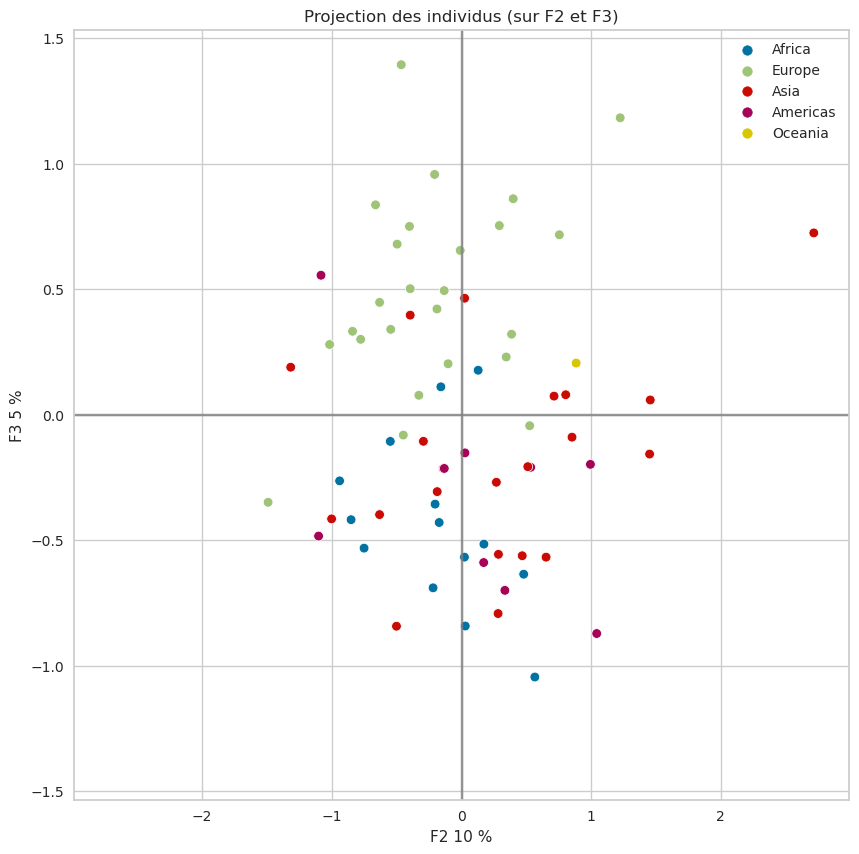

In [50]:
fp4, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,2),clusters=region)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

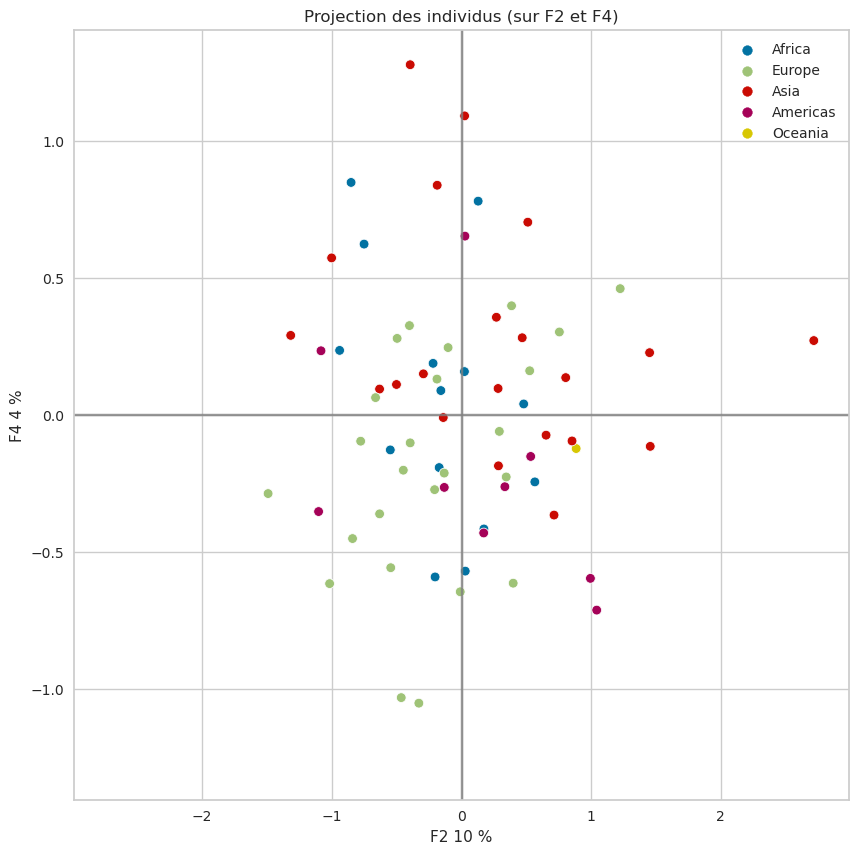

In [51]:
fp5, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,3),clusters=region)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

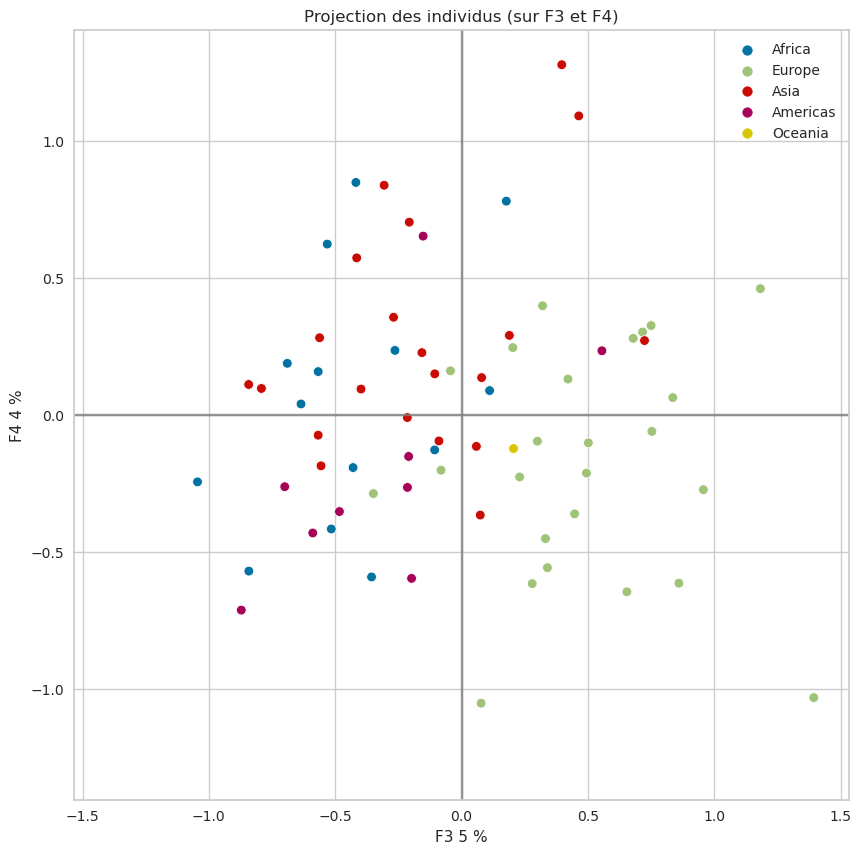

In [52]:
fp6, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(2,3),clusters=region)

## CAH

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

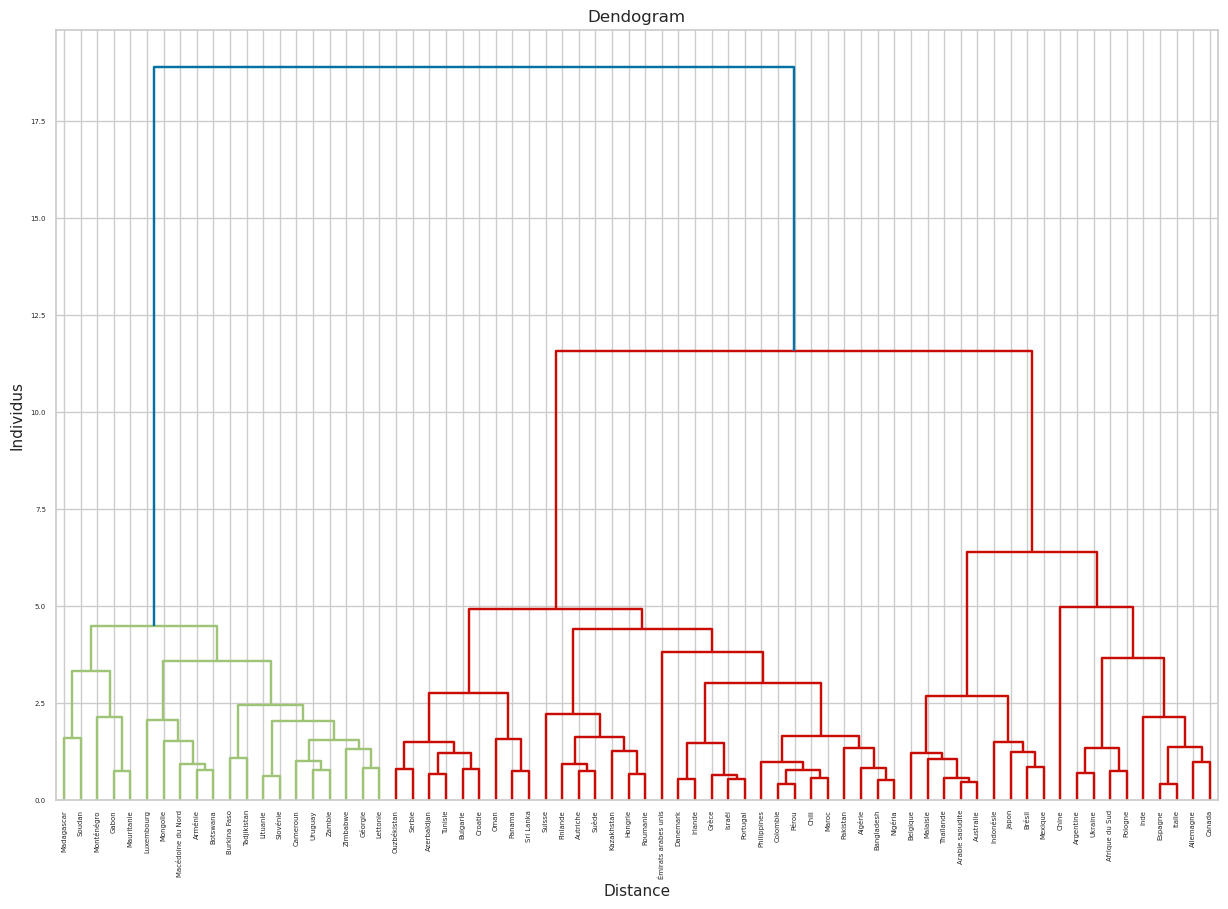

In [53]:
cah3 = CAH(df, columns)
cah3.scale(RobustScaler())
fig, ax = plt.subplots(figsize=(15, 10))
cah3.dendrogram(ax)

Après l'exclusion des pays précédents, nous pouvons voire ici deux cluster relativement homogènes. Nous pourrions même considérer trois clusters (l'un des clusters seraient l'Italie, l'Espagne, le Mexique et le Canada).

## Kmeans

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

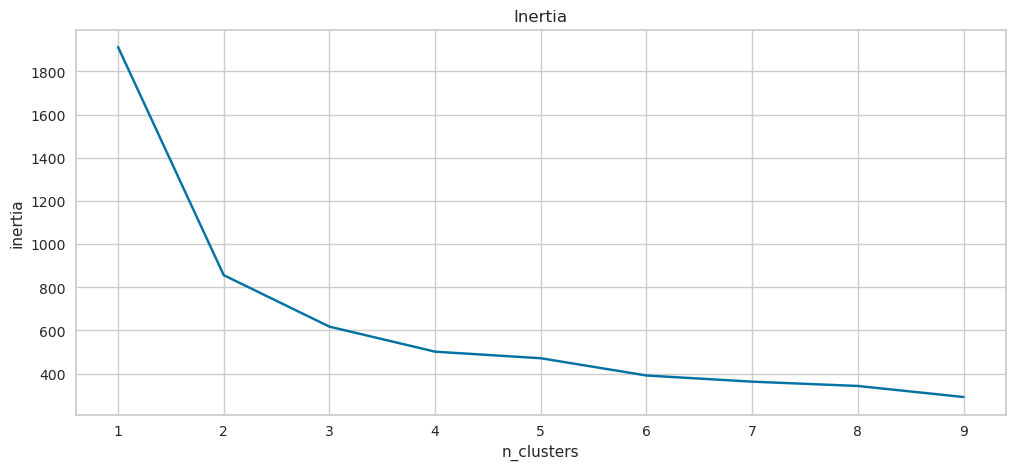

In [54]:
km = kmeans(df, columns)
fig, ax = plt.subplots(figsize=(12, 5))
km.plot_inertia(ax)


For n_clusters = 2, silhouette score is 0.445)
For n_clusters = 3, silhouette score is 0.356)
For n_clusters = 4, silhouette score is 0.288)
For n_clusters = 5, silhouette score is 0.244)
For n_clusters = 6, silhouette score is 0.239)
For n_clusters = 7, silhouette score is 0.212)
For n_clusters = 8, silhouette score is 0.223)
For n_clusters = 9, silhouette score is 0.222)
For n_clusters = 10, silhouette score is 0.191)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

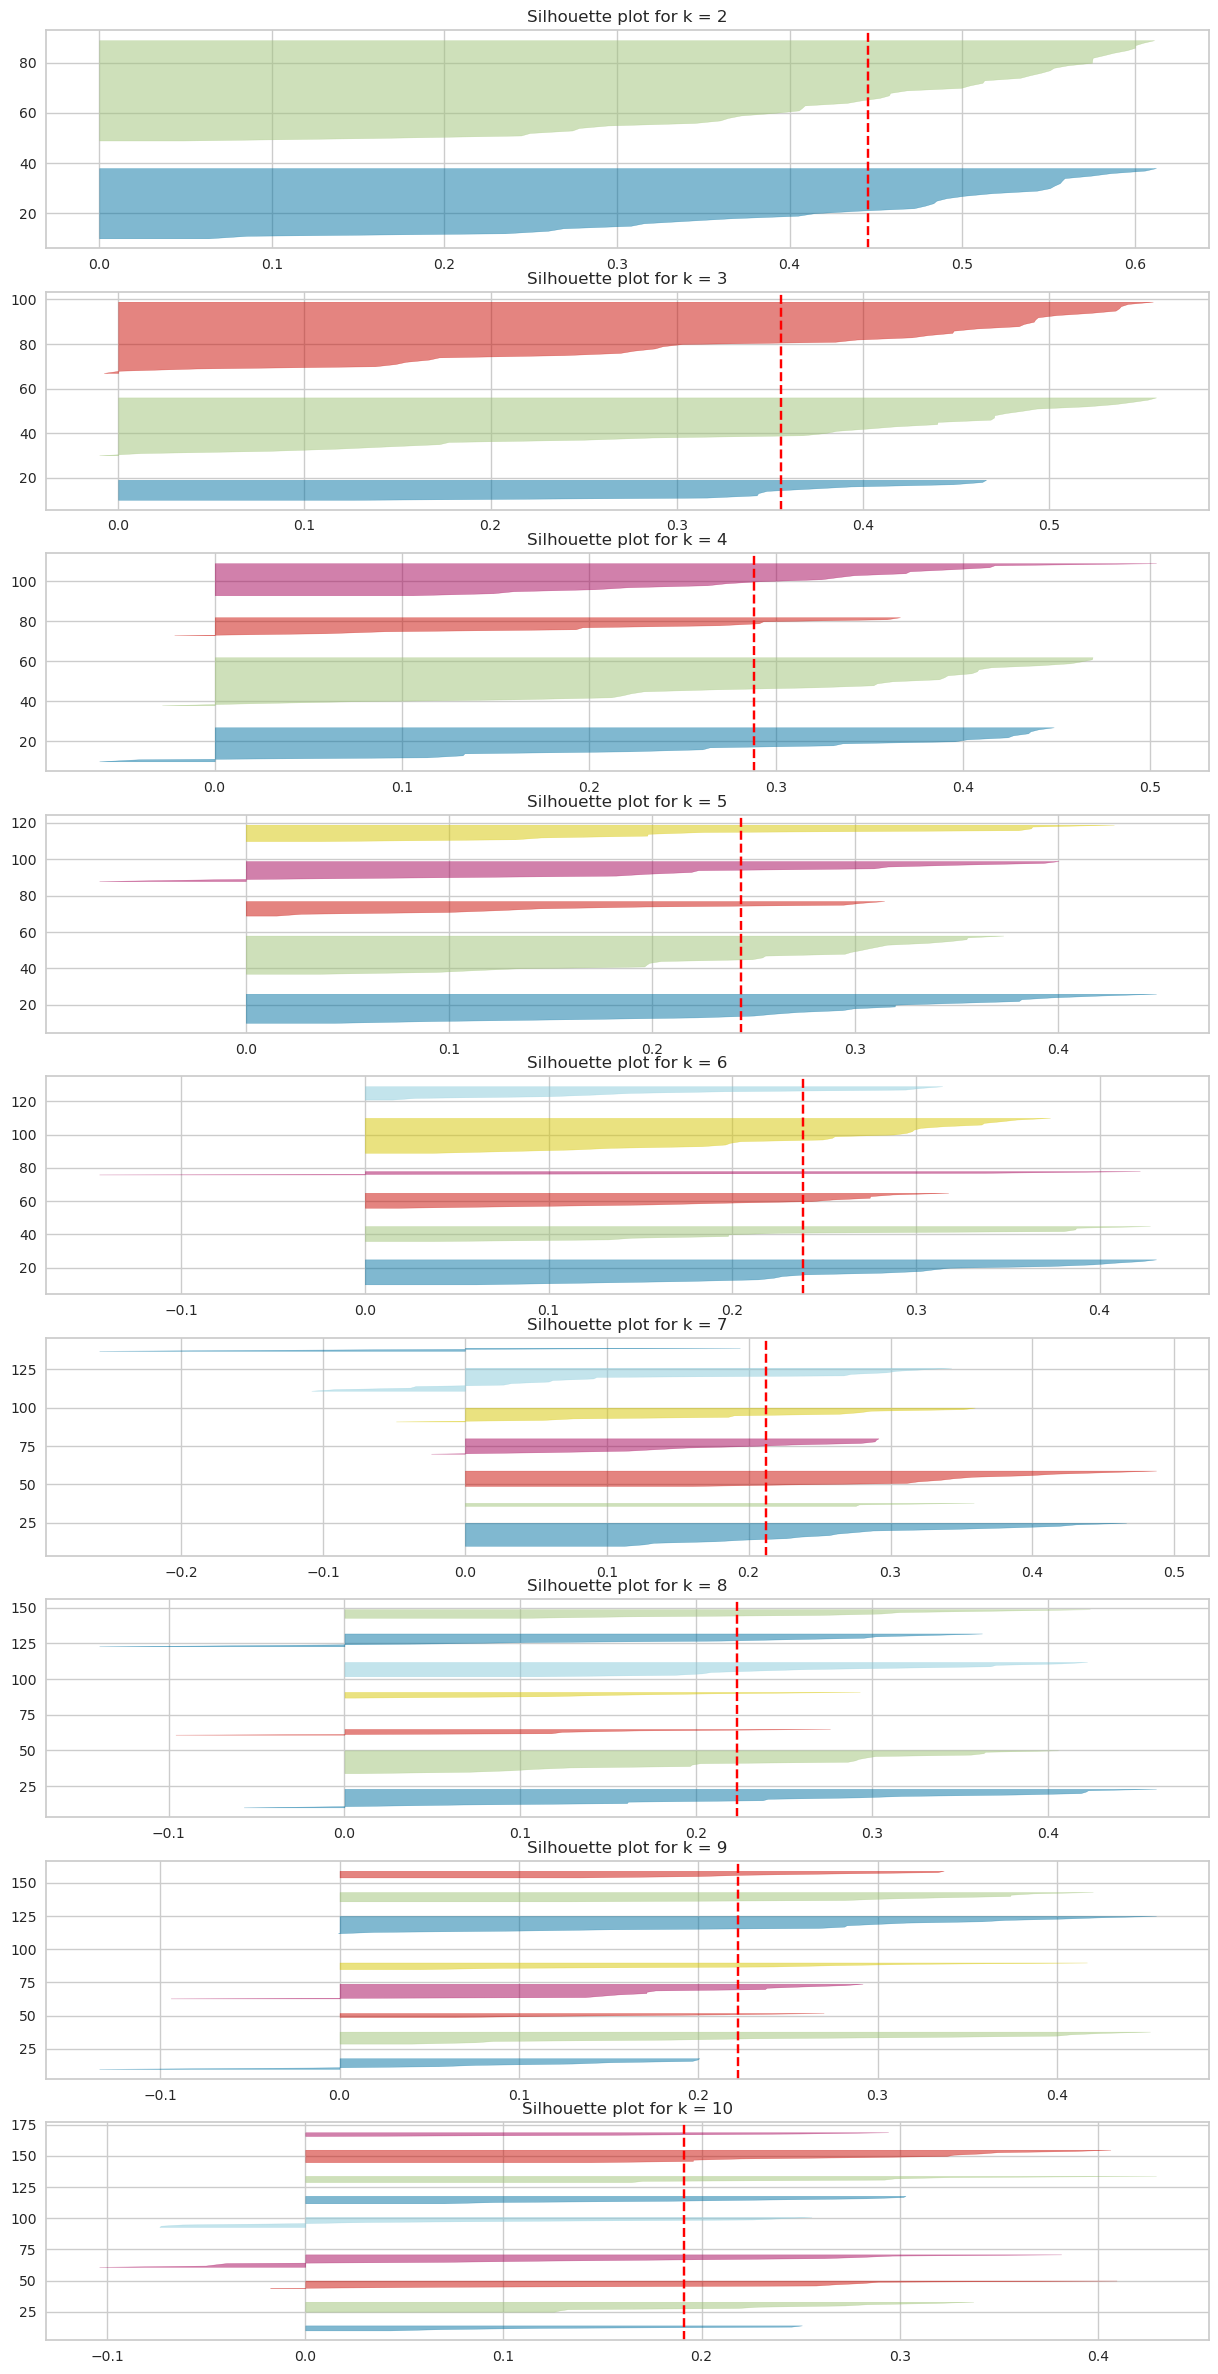

In [55]:
fig, ax = plt.subplots(9,1,figsize=(15, 30))
km.plot_silhouette(ax,[2,3,4,5,6,7,8,9,10])

Si la méthode du coude semble indiquer clairement 2 clusters, la méthode de la silhouette donne un résultat intérssant pour 5 clusters (Les groupes sont éssez homogènes et dépassent tous les coefficient de silouhette). Nous allons étudier ces deux cas.

In [56]:
km.kmean_choose(2)
km.clusters

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0], dtype=int32)

In [57]:
df['cluster']=km.clusters
columns.append('cluster')

### 2 Clusters

In [58]:
df.columns

Index(['CO2 emissions (kt)',
       'Container port traffic (TEU: 20 foot equivalent units)',
       'Merchandise exports (current US$)',
       'Merchandise imports (current US$)', 'Rail lines (total route-km)',
       'PIB Valeur US $', 'Volailles - Production (Milliers de tonnes)',
       'Population urbaine', 'Aliments Volailles (milliers de tonnes)',
       'cluster'],
      dtype='object')

In [59]:
km_df = df[columns]

Text(0.5, 0.98, 'Boxplot by clusters for each features')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

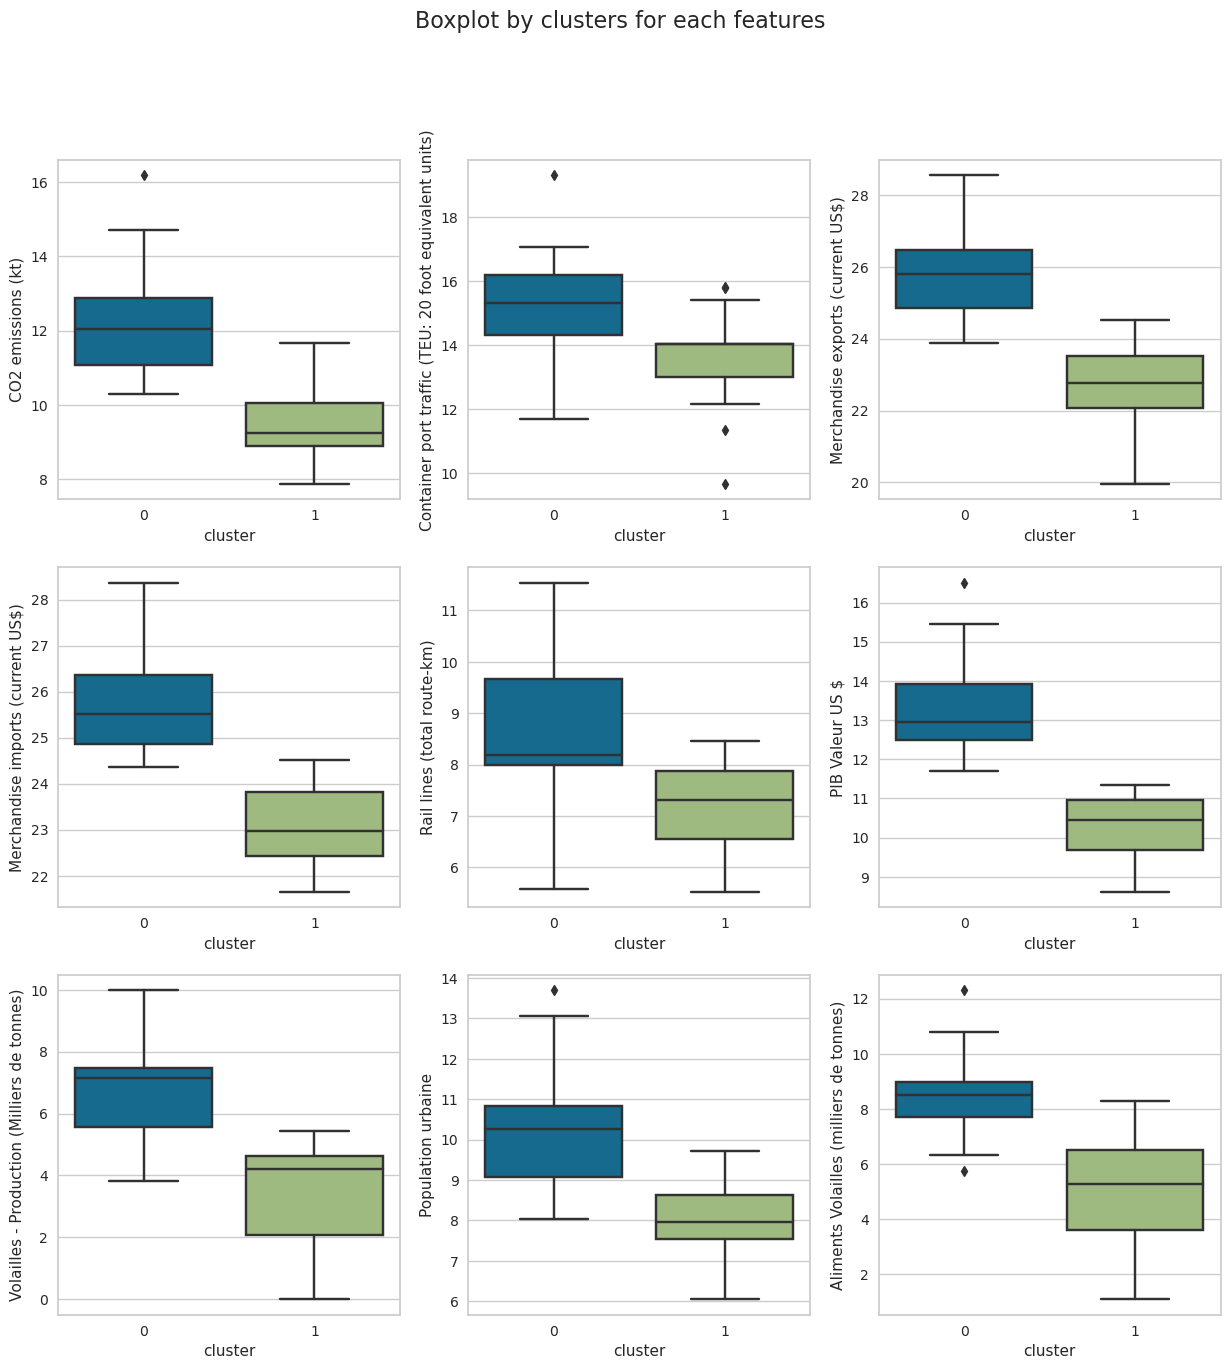

In [60]:
# box plot by clusters for each feature
fig, ax = plt.subplots(3,3,figsize=(15, 15))
sns.boxplot(x="cluster", y="CO2 emissions (kt)", data=km_df, ax=ax[0,0])
sns.boxplot(x="cluster", y="Container port traffic (TEU: 20 foot equivalent units)", data=km_df, ax=ax[0,1])
sns.boxplot(x="cluster", y="Merchandise exports (current US$)", data=km_df, ax=ax[0,2])
sns.boxplot(x="cluster", y="Merchandise imports (current US$)", data=km_df, ax=ax[1,0])
sns.boxplot(x="cluster", y="Rail lines (total route-km)", data=km_df, ax=ax[1,1])
sns.boxplot(x="cluster", y="PIB Valeur US $", data=km_df, ax=ax[1,2])
sns.boxplot(x="cluster", y="Volailles - Production (Milliers de tonnes)", data=km_df, ax=ax[2,0])
sns.boxplot(x="cluster", y="Population urbaine", data=km_df, ax=ax[2,1])
sns.boxplot(x="cluster", y="Aliments Volailles (milliers de tonnes)", data=km_df, ax=ax[2,2])
fig.suptitle('Boxplot by clusters for each features', fontsize=16)

Dans ce cas, le cluster 1 semble être le cluster le plus intéressant sur lequel approffondir une étude de marché.
-Les produits d'alimentation de ce cluster sont plus accessible que le cluster 0 (malgré une énorme variance à ce niveau là)  
-Le PIB par habitant est plus élevé que le cluster 0
-En ce qui concerne les imports/exports, le réseau féroviaire ou le transfet de marchandise par voie maritime, le cluster 1 est au dessus du cluster 0.

Il est aussi intéressant de noter une population plus urbaine dans le cluster 1 et une émission de CO2 élevée.

In [61]:
cluster0 = km_df[km_df['cluster']==0]
cluster0

CO2 emissions (kt)  \
Zone                                      
Afrique du Sud                13.009479   
Algérie                       12.046980   
Allemagne                     13.398015   
Arabie saoudite               13.174522   
Argentine                     12.032689   
Australie                     12.887147   
Autriche                      11.074402   
Bangladesh                    11.436541   
Belgique                      11.440252   
Brésil                        12.981535   
Canada                        13.246354   
Chili                         11.428635   
Chine                         16.191609   
Colombie                      11.279576   
Danemark                      10.298818   
Espagne                       12.396228   
Finlande                      10.621037   
Grèce                         11.001955   
Hongrie                       10.763479   
Inde                          14.700910   
Indonésie                     13.313466   
Irlande                       10.486072   
Israël                        11.047667   
Italie                        12.667363   
Japon                         13.886571   
Kazakhstan                    12.228779   
Malaisie                      12.408536   
Maroc                         11.170256   
Mexique                       13.021061   
Nigéria                       11.691449   
Pakistan                      12.123220   
Philippines                   11.890487   
Pologne                       12.594559   
Portugal                      10.704720   
Pérou                         10.950336   
Roumanie                      11.211061   
Suisse                        10.528819   
Suède                         10.462120   
Thaïlande                     12.522589   
Ukraine                       12.070258   
Émirats arabes unis           12.131601   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Afrique du Sud                                               15.326019        
Algérie                                                      14.399953        
Allemagne                                                    16.525533        
Arabie saoudite                                              16.002193        
Argentine                                                    14.421991        
Australie                                                    15.987511        
Autriche                                                     14.021778        
Bangladesh                                                   14.961617        
Belgique                                                     16.332390        
Brésil                                                       16.186191        
Canada                                                       15.761440        
Chili                                                        15.351751        
Chine                                                        19.310874        
Colombie                                                     15.278040        
Danemark                                                     13.687723        
Espagne                                                      16.675705        
Finlande                                                     14.302968        
Grèce                                                        15.632543        
Hongrie                                                      14.021778        
Inde                                                         16.677004        
Indonésie                                                    16.309664        
Irlande                                                      13.877067        
Israël                                                       14.886067        
Italie                                                       16.194069        
Japon                                                        16.962954        
Kazakhstan                            

In [62]:
cluster1 = km_df[km_df['cluster']==1]
cluster1

CO2 emissions (kt)  \
Zone                                    
Arménie                      8.731756   
Azerbaïdjan                 10.477908   
Botswana                     8.881739   
Bulgarie                    10.575434   
Burkina Faso                 8.638968   
Cameroun                     9.165165   
Croatie                      9.712587   
Gabon                        8.570829   
Géorgie                      9.263938   
Lettonie                     8.931962   
Lituanie                     9.370484   
Luxembourg                   9.159184   
Macédoine du Nord            8.981820   
Madagascar                   8.276064   
Mauritanie                   8.249523   
Mongolie                    10.049659   
Monténégro                   7.864074   
Oman                        11.235138   
Ouzbékistan                 11.675799   
Panama                       9.480436   
Serbie                      10.737073   
Slovénie                     9.522666   
Soudan                      10.004802   
Sri Lanka                   10.061726   
Tadjikistan                  9.101273   
Tunisie                     10.343225   
Uruguay                      8.825810   
Zambie                       8.938098   
Zimbabwe                     9.228799   

                   Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                        
Arménie                                                    14.021778        
Azerbaïdjan                                                14.021778        
Botswana                                                   14.021778        
Bulgarie                                                   12.475852        
Burkina Faso                                               14.021778        
Cameroun                                                   12.823111        
Croatie                                                    12.761210        
Gabon                                                      12.170440        
Géorgie                                                    13.307169        
Lettonie                                                   13.016672        
Lituanie                                                   13.463114        
Luxembourg                                                 14.021778        
Macédoine du Nord                                          14.021778        
Madagascar                                                 12.204639        
Mauritanie                                                 11.344021        
Mongolie                                                   14.021778        
Monténégro                                                  9.664304        
Oman                                                       15.402799        
Ouzbékistan                                                14.021778        
Panama                                                     15.809784        
Serbie                                                     14.021778        
Slovénie                                                   13.773647        
Soudan                                                     13.059481        
Sri Lanka                                                  15.793750        
Tadjikistan                                                14.021778        
Tunisie                                                    13.069433        
Uruguay                                                    13.527246        
Zambie                                                     14.021778        
Zimbabwe                                                   14.021778        

                   Merchandise exports (current US$)  \
Zone                                                   
Arménie                                    21.694045   
Azerbaïdjan                                23.700580   
Botswana                                   22.379015   
Bulgarie                                   24.230024   
Burkina Faso           

#### Projection des individus sur F1/F2/F3/F4

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

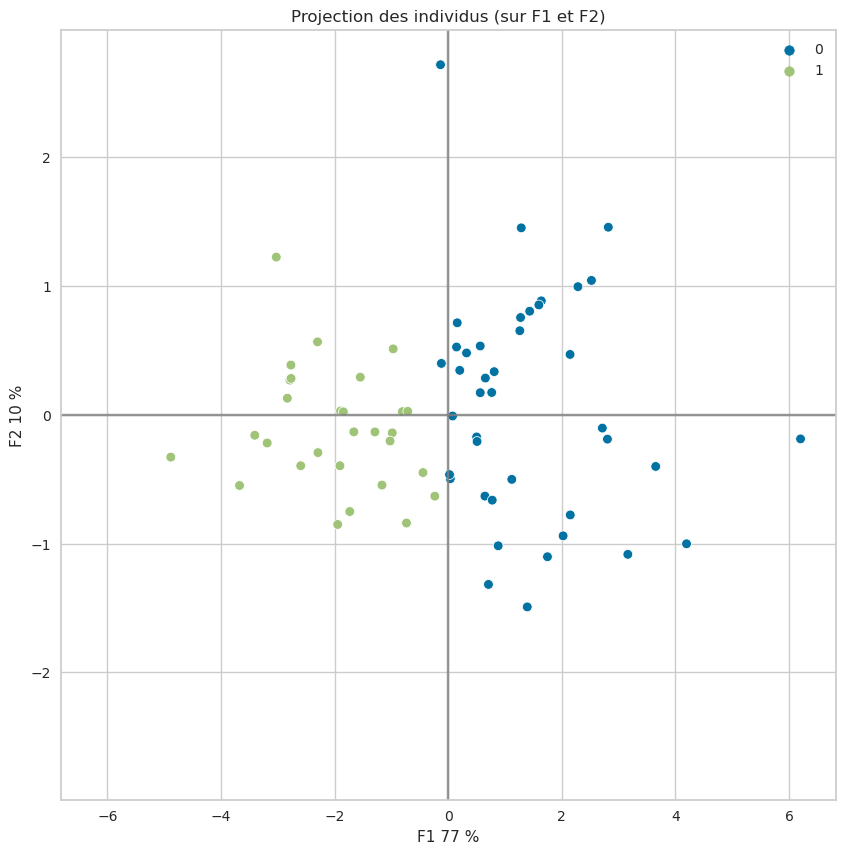

In [63]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,1), clusters=km.clusters)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

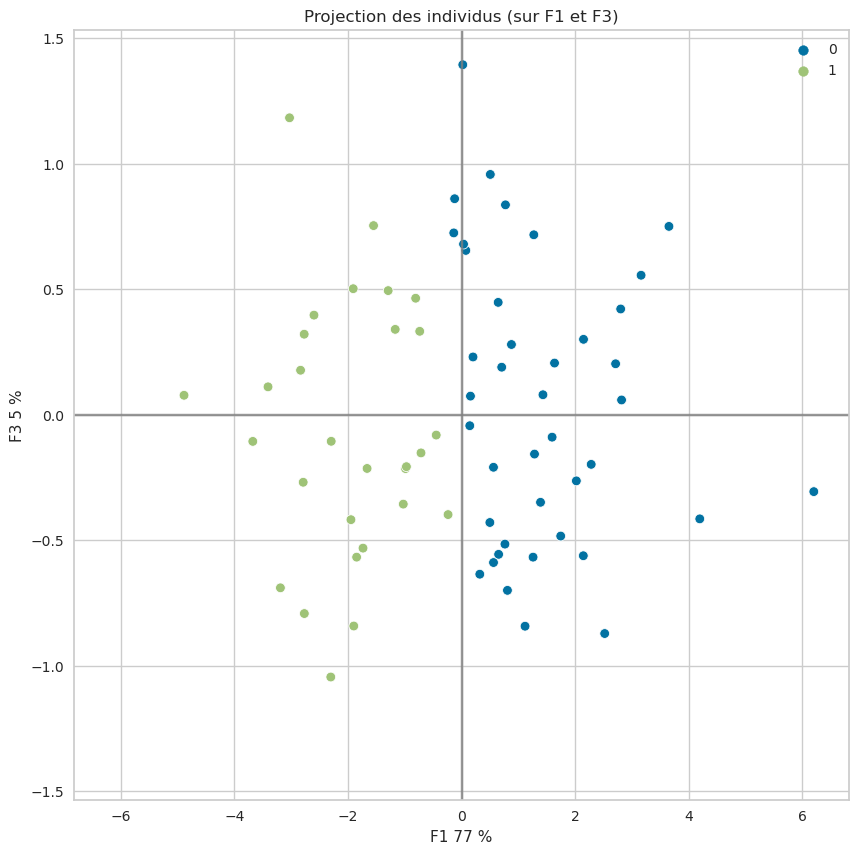

In [64]:
fp2, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,2),clusters=km.clusters)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

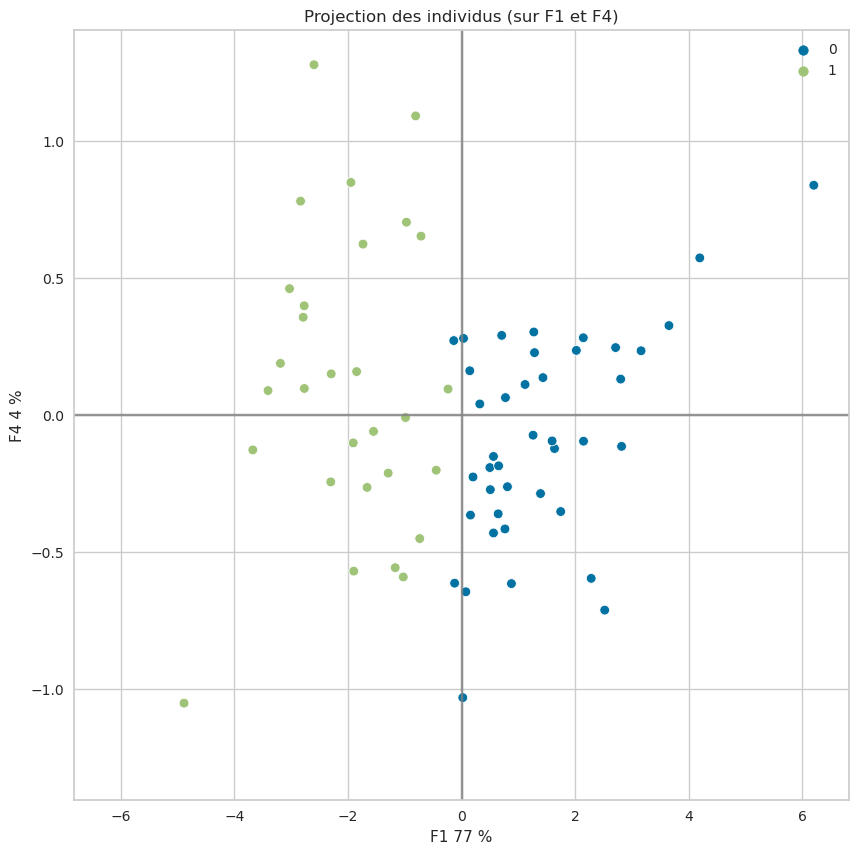

In [65]:
fp3, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,3),clusters=km.clusters)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

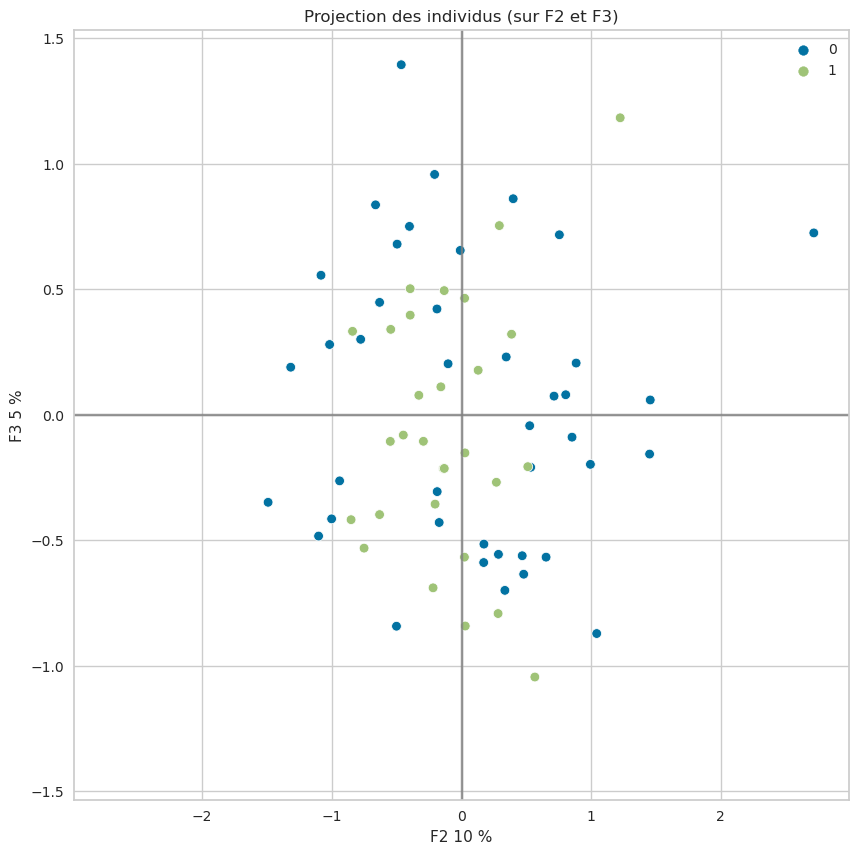

In [66]:
fp4, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,2),clusters=km.clusters)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

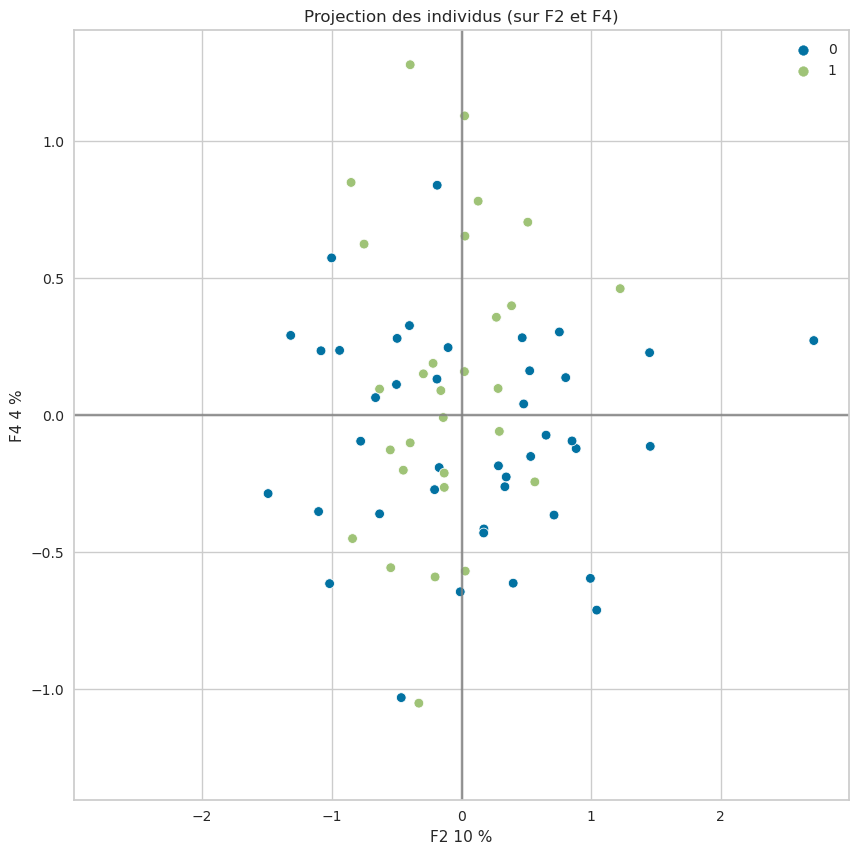

In [67]:
fp5, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,3),clusters=km.clusters)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
f

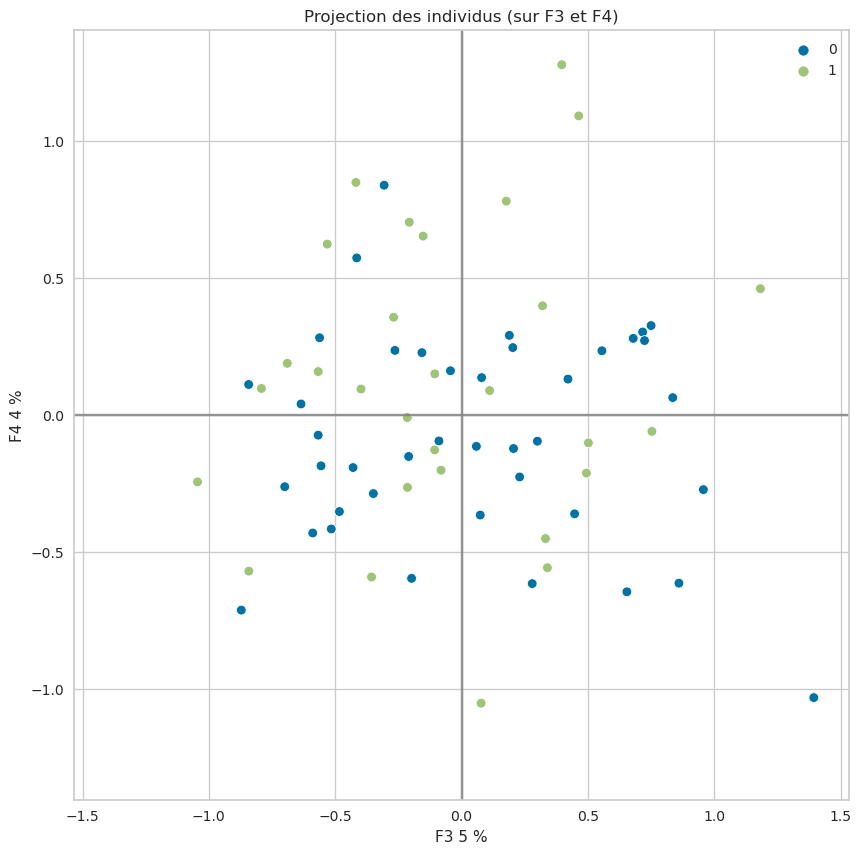

In [68]:
fp6, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(2,3),clusters=km.clusters)

Globalement, le cluster 1 se démarque bien du cluster 0.

### X Clusters 

In [69]:
df = df.drop(columns=['cluster'])
km.kmean_choose(4)
km.clusters

array([0, 0, 2, 0, 0, 1, 0, 3, 3, 0, 0, 1, 2, 3, 1, 1, 2, 0, 2, 0, 3, 3,
       2, 3, 1, 0, 1, 0, 2, 2, 3, 0, 2, 2, 3, 1, 3, 1, 1, 1, 0, 0, 1, 2,
       1, 1, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 3, 3, 1, 3, 3, 3, 1, 0, 3, 0,
       1, 1, 1, 0], dtype=int32)

In [70]:
df

CO2 emissions (kt)  \
Zone                                      
Afrique du Sud                13.009479   
Algérie                       12.046980   
Allemagne                     13.398015   
Arabie saoudite               13.174522   
Argentine                     12.032689   
...                                 ...   
Ukraine                       12.070258   
Uruguay                        8.825810   
Zambie                         8.938098   
Zimbabwe                       9.228799   
Émirats arabes unis           12.131601   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Afrique du Sud                                               15.326019        
Algérie                                                      14.399953        
Allemagne                                                    16.525533        
Arabie saoudite                                              16.002193        
Argentine                                                    14.421991        
...                                                                ...        
Ukraine                                                      13.822758        
Uruguay                                                      13.527246        
Zambie                                                       14.021778        
Zimbabwe                                                     14.021778        
Émirats arabes unis                                          16.749474        

                     Merchandise exports (current US$)  \
Zone                                                     
Afrique du Sud                               25.223253   
Algérie                                      24.287489   
Allemagne                                    28.029403   
Arabie saoudite                              26.290094   
Argentine                                    24.899436   
...                                                ...   
Ukraine                                      24.636368   
Uruguay                                      22.761885   
Zambie                                       22.674732   
Zimbabwe                                     22.174645   
Émirats arabes unis                          26.687945   

                     Merchandise imports (current US$)  \
Zone                                                     
Afrique du Sud                               25.401119   
Algérie                                      24.521717   
Allemagne                                    27.841264   
Arabie saoudite                              25.754769   
Argentine                                    24.617614   
...                                                ...   
Ukraine                                      24.830856   
Uruguay                                      22.832994   
Zambie                                       22.693590   
Zimbabwe                                     22.295417   
Émirats arabes unis                          26.387777   

                     Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                                
Afrique du Sud                          9.950085        12.769771   
Algérie                                 8.299348        12.050350   
Allemagne                              10.417029        15.173490   
Arabie saoudite                         7.999175        13.583538   
Argentine                               9.790711        13.006832   
...                                          ...              ...   
Ukraine                                 9.981693        11.944257   
Uruguay                                 7.312553        11.022428   
Zambie                                  7.130099        10.056669   
Zimbabwe                                8.045909         9.995888   
Émirats arabes unis                     5.568345        12.941361   

                     Vola

In [71]:
df['cluster']=km.clusters
columns.append('cluster')

In [72]:
df.columns

Index(['CO2 emissions (kt)',
       'Container port traffic (TEU: 20 foot equivalent units)',
       'Merchandise exports (current US$)',
       'Merchandise imports (current US$)', 'Rail lines (total route-km)',
       'PIB Valeur US $', 'Volailles - Production (Milliers de tonnes)',
       'Population urbaine', 'Aliments Volailles (milliers de tonnes)',
       'cluster'],
      dtype='object')

In [73]:
km_df = df.copy() 

In [74]:
km_df

CO2 emissions (kt)  \
Zone                                      
Afrique du Sud                13.009479   
Algérie                       12.046980   
Allemagne                     13.398015   
Arabie saoudite               13.174522   
Argentine                     12.032689   
...                                 ...   
Ukraine                       12.070258   
Uruguay                        8.825810   
Zambie                         8.938098   
Zimbabwe                       9.228799   
Émirats arabes unis           12.131601   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Afrique du Sud                                               15.326019        
Algérie                                                      14.399953        
Allemagne                                                    16.525533        
Arabie saoudite                                              16.002193        
Argentine                                                    14.421991        
...                                                                ...        
Ukraine                                                      13.822758        
Uruguay                                                      13.527246        
Zambie                                                       14.021778        
Zimbabwe                                                     14.021778        
Émirats arabes unis                                          16.749474        

                     Merchandise exports (current US$)  \
Zone                                                     
Afrique du Sud                               25.223253   
Algérie                                      24.287489   
Allemagne                                    28.029403   
Arabie saoudite                              26.290094   
Argentine                                    24.899436   
...                                                ...   
Ukraine                                      24.636368   
Uruguay                                      22.761885   
Zambie                                       22.674732   
Zimbabwe                                     22.174645   
Émirats arabes unis                          26.687945   

                     Merchandise imports (current US$)  \
Zone                                                     
Afrique du Sud                               25.401119   
Algérie                                      24.521717   
Allemagne                                    27.841264   
Arabie saoudite                              25.754769   
Argentine                                    24.617614   
...                                                ...   
Ukraine                                      24.830856   
Uruguay                                      22.832994   
Zambie                                       22.693590   
Zimbabwe                                     22.295417   
Émirats arabes unis                          26.387777   

                     Rail lines (total route-km)  PIB Valeur US $  \
Zone                                                                
Afrique du Sud                          9.950085        12.769771   
Algérie                                 8.299348        12.050350   
Allemagne                              10.417029        15.173490   
Arabie saoudite                         7.999175        13.583538   
Argentine                               9.790711        13.006832   
...                                          ...              ...   
Ukraine                                 9.981693        11.944257   
Uruguay                                 7.312553        11.022428   
Zambie                                  7.130099        10.056669   
Zimbabwe                                8.045909         9.995888   
Émirats arabes unis                     5.568345        12.941361   

                     Vola

In [75]:
cluster0 = km_df[km_df['cluster']==0]
cluster1 = km_df[km_df['cluster']==1]
cluster2 = km_df[km_df['cluster']==2]
cluster3 = km_df[km_df['cluster']==3]
cluster4 = km_df[km_df['cluster']==4]
cluster5 = km_df[km_df['cluster']==5]
cluster6 = km_df[km_df['cluster']==6]
cluster7 = km_df[km_df['cluster']==7]
cluster8 = km_df[km_df['cluster']==8]
cluster9 = km_df[km_df['cluster']==9]

In [76]:
cluster0

CO2 emissions (kt)  \
Zone                                      
Afrique du Sud                13.009479   
Algérie                       12.046980   
Arabie saoudite               13.174522   
Argentine                     12.032689   
Australie                     12.887147   
Bangladesh                    11.436541   
Belgique                      11.440252   
Chili                         11.428635   
Colombie                      11.279576   
Grèce                         11.001955   
Hongrie                       10.763479   
Israël                        11.047667   
Malaisie                      12.408536   
Maroc                         11.170256   
Nigéria                       11.691449   
Pakistan                      12.123220   
Philippines                   11.890487   
Pologne                       12.594559   
Portugal                      10.704720   
Pérou                         10.950336   
Roumanie                      11.211061   
Thaïlande                     12.522589   
Ukraine                       12.070258   
Émirats arabes unis           12.131601   

                     Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                          
Afrique du Sud                                               15.326019        
Algérie                                                      14.399953        
Arabie saoudite                                              16.002193        
Argentine                                                    14.421991        
Australie                                                    15.987511        
Bangladesh                                                   14.961617        
Belgique                                                     16.332390        
Chili                                                        15.351751        
Colombie                                                     15.278040        
Grèce                                                        15.632543        
Hongrie                                                      14.021778        
Israël                                                       14.886067        
Malaisie                                                     17.081855        
Maroc                                                        15.618672        
Nigéria                                                      14.302336        
Pakistan                                                     14.962913        
Philippines                                                  16.031660        
Pologne                                                      14.929499        
Portugal                                                     14.881630        
Pérou                                                        14.800297        
Roumanie                                                     13.409101        
Thaïlande                                                    16.131041        
Ukraine                                                      13.822758        
Émirats arabes unis                                          16.749474        

                     Merchandise exports (current US$)  \
Zone                                                     
Afrique du Sud                               25.223253   
Algérie                                      24.287489   
Arabie saoudite                              26.290094   
Argentine                                    24.899436   
Australie                                    26.325403   
Bangladesh                                   24.395431   
Belgique                                     26.825623   
Chili                                        24.954382   
Colombie                                     24.399288   
Grèce                                        24.358402   
Hongrie                                      25.541901   
Israël                                       24.792412   
Malaisie                           

Il est intéressant ici de remarquer qu'hormis l'Indonésie, nous n'avons dans ce cluster que des pays appertenant à l'U.E. Si ces pays ne produisent pas beaucoup de volaille, peut-être est-il possible d'en exporter ! Le fait que ces pays apprtiennent à l'U.E pourrait-être un avantage pour l'exportation.

In [77]:
cluster1

CO2 emissions (kt)  \
Zone                                    
Arménie                      8.731756   
Botswana                     8.881739   
Burkina Faso                 8.638968   
Cameroun                     9.165165   
Gabon                        8.570829   
Géorgie                      9.263938   
Lettonie                     8.931962   
Luxembourg                   9.159184   
Macédoine du Nord            8.981820   
Madagascar                   8.276064   
Mauritanie                   8.249523   
Mongolie                    10.049659   
Monténégro                   7.864074   
Soudan                      10.004802   
Tadjikistan                  9.101273   
Uruguay                      8.825810   
Zambie                       8.938098   
Zimbabwe                     9.228799   

                   Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                        
Arménie                                                    14.021778        
Botswana                                                   14.021778        
Burkina Faso                                               14.021778        
Cameroun                                                   12.823111        
Gabon                                                      12.170440        
Géorgie                                                    13.307169        
Lettonie                                                   13.016672        
Luxembourg                                                 14.021778        
Macédoine du Nord                                          14.021778        
Madagascar                                                 12.204639        
Mauritanie                                                 11.344021        
Mongolie                                                   14.021778        
Monténégro                                                  9.664304        
Soudan                                                     13.059481        
Tadjikistan                                                14.021778        
Uruguay                                                    13.527246        
Zambie                                                     14.021778        
Zimbabwe                                                   14.021778        

                   Merchandise exports (current US$)  \
Zone                                                   
Arménie                                    21.694045   
Botswana                                   22.379015   
Burkina Faso                               21.898530   
Cameroun                                   22.130343   
Gabon                                      22.628652   
Géorgie                                    22.057740   
Lettonie                                   23.477245   
Luxembourg                                 23.523652   
Macédoine du Nord                          22.695818   
Madagascar                                 21.715035   
Mauritanie                                 21.541282   
Mongolie                                   22.754042   
Monténégro                                 19.957548   
Soudan                                     22.041014   
Tadjikistan                                20.883683   
Uruguay                                    22.761885   
Zambie                                     22.674732   
Zimbabwe                                   22.174645   

                   Merchandise imports (current US$)  \
Zone                                                   
Arménie                                    22.430556   
Botswana                                   22.604866   
Burkina Faso                               22.178153   
Cameroun                                   22.607756   
Gabon                                      21.654642   
Géorgie                                    22.976661   
Lettonie                                   23.665545   
Luxembourg                      

Nous pouvons remarqué que sur le cluster 1, nous retrouvons l'Espagne, l'Italie et le Mexique. Ces pays appartenaient au troisième cluster de notre CAH.
Si l'on regarde la production de volaille dans ces pays, nous pouvons y voir une variance très faible. Ceci est un avantage non négligeable. Si la production est stable, il est plus facile de prévoir le besoin de matière première pour la production de volaille (le blé et le Maîs). Il est aussi plus facile de prévoir les ventes de volaille.

In [78]:
cluster2

CO2 emissions (kt)  \
Zone                            
Allemagne           13.398015   
Brésil              12.981535   
Canada              13.246354   
Chine               16.191609   
Espagne             12.396228   
Inde                14.700910   
Indonésie           13.313466   
Italie              12.667363   
Japon               13.886571   
Mexique             13.021061   

           Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                
Allemagne                                          16.525533        
Brésil                                             16.186191        
Canada                                             15.761440        
Chine                                              19.310874        
Espagne                                            16.675705        
Inde                                               16.677004        
Indonésie                                          16.309664        
Italie                                             16.194069        
Japon                                              16.962954        
Mexique                                            15.777558        

           Merchandise exports (current US$)  \
Zone                                           
Allemagne                          28.029403   
Brésil                             26.122003   
Canada                             26.829881   
Chine                              28.547095   
Espagne                            26.534461   
Inde                               26.505058   
Indonésie                          25.845341   
Italie                             27.010600   
Japon                              27.282263   
Mexique                            26.855805   

           Merchandise imports (current US$)  Rail lines (total route-km)  \
Zone                                                                        
Allemagne                          27.841264                    10.417029   
Brésil                             25.986795                     7.999175   
Canada                             26.860978                    10.778716   
Chine                              28.362613                    11.537257   
Espagne                            26.644174                     9.662625   
Inde                               26.909596                    11.118624   
Indonésie                          25.866542                     8.609590   
Italie                             26.886593                     9.727919   
Japon                              27.303845                     7.999175   
Mexique                            26.869848                     7.999175   

           PIB Valeur US $  Volailles - Production (Milliers de tonnes)  \
Zone                                                                      
Allemagne        15.173490                                     7.342779   
Brésil           14.449977                                     9.553575   
Canada           14.370256                                     7.317876   
Chine            16.503414                                     9.976692   
Espagne          14.147004                                     7.397562   
Inde             14.876750                                     8.386629   
Indonésie        13.928028                                     8.288032   
Italie           14.513339                                     7.214504   
Japon            15.454271                                     7.740230   
Mexique          14.053637                                     8.165079   

           Population urbaine  Aliments Volailles (milliers de tonnes)  \
Zone                                                                     
Allemagne           11.063328                                 9.466609   
Brésil              12.124909                                10.772037   
Canada              10.321450                                 9.651623   
Chine       

Le cluster 2 est le moins intéressant à mon sens. Il est composé de beaucoup de pays et comme vue précédemment, il produit peu de volaille, importe peu, exporte peu.

In [79]:
cluster3

CO2 emissions (kt)  \
Zone                              
Autriche              11.074402   
Azerbaïdjan           10.477908   
Bulgarie              10.575434   
Croatie                9.712587   
Danemark              10.298818   
Finlande              10.621037   
Irlande               10.486072   
Kazakhstan            12.228779   
Lituanie               9.370484   
Oman                  11.235138   
Ouzbékistan           11.675799   
Panama                 9.480436   
Serbie                10.737073   
Slovénie               9.522666   
Sri Lanka             10.061726   
Suisse                10.528819   
Suède                 10.462120   
Tunisie               10.343225   

             Container port traffic (TEU: 20 foot equivalent units)  \
Zone                                                                  
Autriche                                             14.021778        
Azerbaïdjan                                          14.021778        
Bulgarie                                             12.475852        
Croatie                                              12.761210        
Danemark                                             13.687723        
Finlande                                             14.302968        
Irlande                                              13.877067        
Kazakhstan                                           14.021778        
Lituanie                                             13.463114        
Oman                                                 15.402799        
Ouzbékistan                                          14.021778        
Panama                                               15.809784        
Serbie                                               14.021778        
Slovénie                                             13.773647        
Sri Lanka                                            15.793750        
Suisse                                               11.706574        
Suède                                                14.300011        
Tunisie                                              13.069433        

             Merchandise exports (current US$)  \
Zone                                             
Autriche                             25.908806   
Azerbaïdjan                          23.700580   
Bulgarie                             24.230024   
Croatie                              23.567012   
Danemark                             25.433480   
Finlande                             25.020116   
Irlande                              25.856856   
Kazakhstan                           24.771724   
Lituanie                             24.224339   
Oman                                 24.379725   
Ouzbékistan                          23.364036   
Panama                               23.149660   
Serbie                               23.700325   
Slovénie                             24.528661   
Sri Lanka                            23.203160   
Suisse                               26.472449   
Suède                                25.802033   
Tunisie                              23.426839   

             Merchandise imports (current US$)  Rail lines (total route-km)  \
Zone                                                                          
Autriche                             25.942313                     8.510974   
Azerbaïdjan                          23.338323                     7.668968   
Bulgarie                             24.351944                     8.301770   
Croatie                              24.061168                     7.870166   
Danemark                             25.310109                     7.999175   
Finlande                             25.023486                     8.686767   
Irlande                              25.339416                     7.543803   
Kazakhstan                           24.354437                     9.684199   
Lituanie                             24.300068                     7.555905   
Oman                 

In [80]:
cluster4

Empty DataFrame
Columns: [CO2 emissions (kt), Container port traffic (TEU: 20 foot equivalent units), Merchandise exports (current US$), Merchandise imports (current US$), Rail lines (total route-km), PIB Valeur US $, Volailles - Production (Milliers de tonnes), Population urbaine, Aliments Volailles (milliers de tonnes), cluster]
Index: []

In [81]:
cluster5

Empty DataFrame
Columns: [CO2 emissions (kt), Container port traffic (TEU: 20 foot equivalent units), Merchandise exports (current US$), Merchandise imports (current US$), Rail lines (total route-km), PIB Valeur US $, Volailles - Production (Milliers de tonnes), Population urbaine, Aliments Volailles (milliers de tonnes), cluster]
Index: []

In [82]:
cluster6

Empty DataFrame
Columns: [CO2 emissions (kt), Container port traffic (TEU: 20 foot equivalent units), Merchandise exports (current US$), Merchandise imports (current US$), Rail lines (total route-km), PIB Valeur US $, Volailles - Production (Milliers de tonnes), Population urbaine, Aliments Volailles (milliers de tonnes), cluster]
Index: []

In [83]:
cluster7

Empty DataFrame
Columns: [CO2 emissions (kt), Container port traffic (TEU: 20 foot equivalent units), Merchandise exports (current US$), Merchandise imports (current US$), Rail lines (total route-km), PIB Valeur US $, Volailles - Production (Milliers de tonnes), Population urbaine, Aliments Volailles (milliers de tonnes), cluster]
Index: []

In [84]:
cluster8

Empty DataFrame
Columns: [CO2 emissions (kt), Container port traffic (TEU: 20 foot equivalent units), Merchandise exports (current US$), Merchandise imports (current US$), Rail lines (total route-km), PIB Valeur US $, Volailles - Production (Milliers de tonnes), Population urbaine, Aliments Volailles (milliers de tonnes), cluster]
Index: []

In [85]:
cluster9

Empty DataFrame
Columns: [CO2 emissions (kt), Container port traffic (TEU: 20 foot equivalent units), Merchandise exports (current US$), Merchandise imports (current US$), Rail lines (total route-km), PIB Valeur US $, Volailles - Production (Milliers de tonnes), Population urbaine, Aliments Volailles (milliers de tonnes), cluster]
Index: []

Text(0.5, 0.98, 'Boxplot by clusters for each features')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

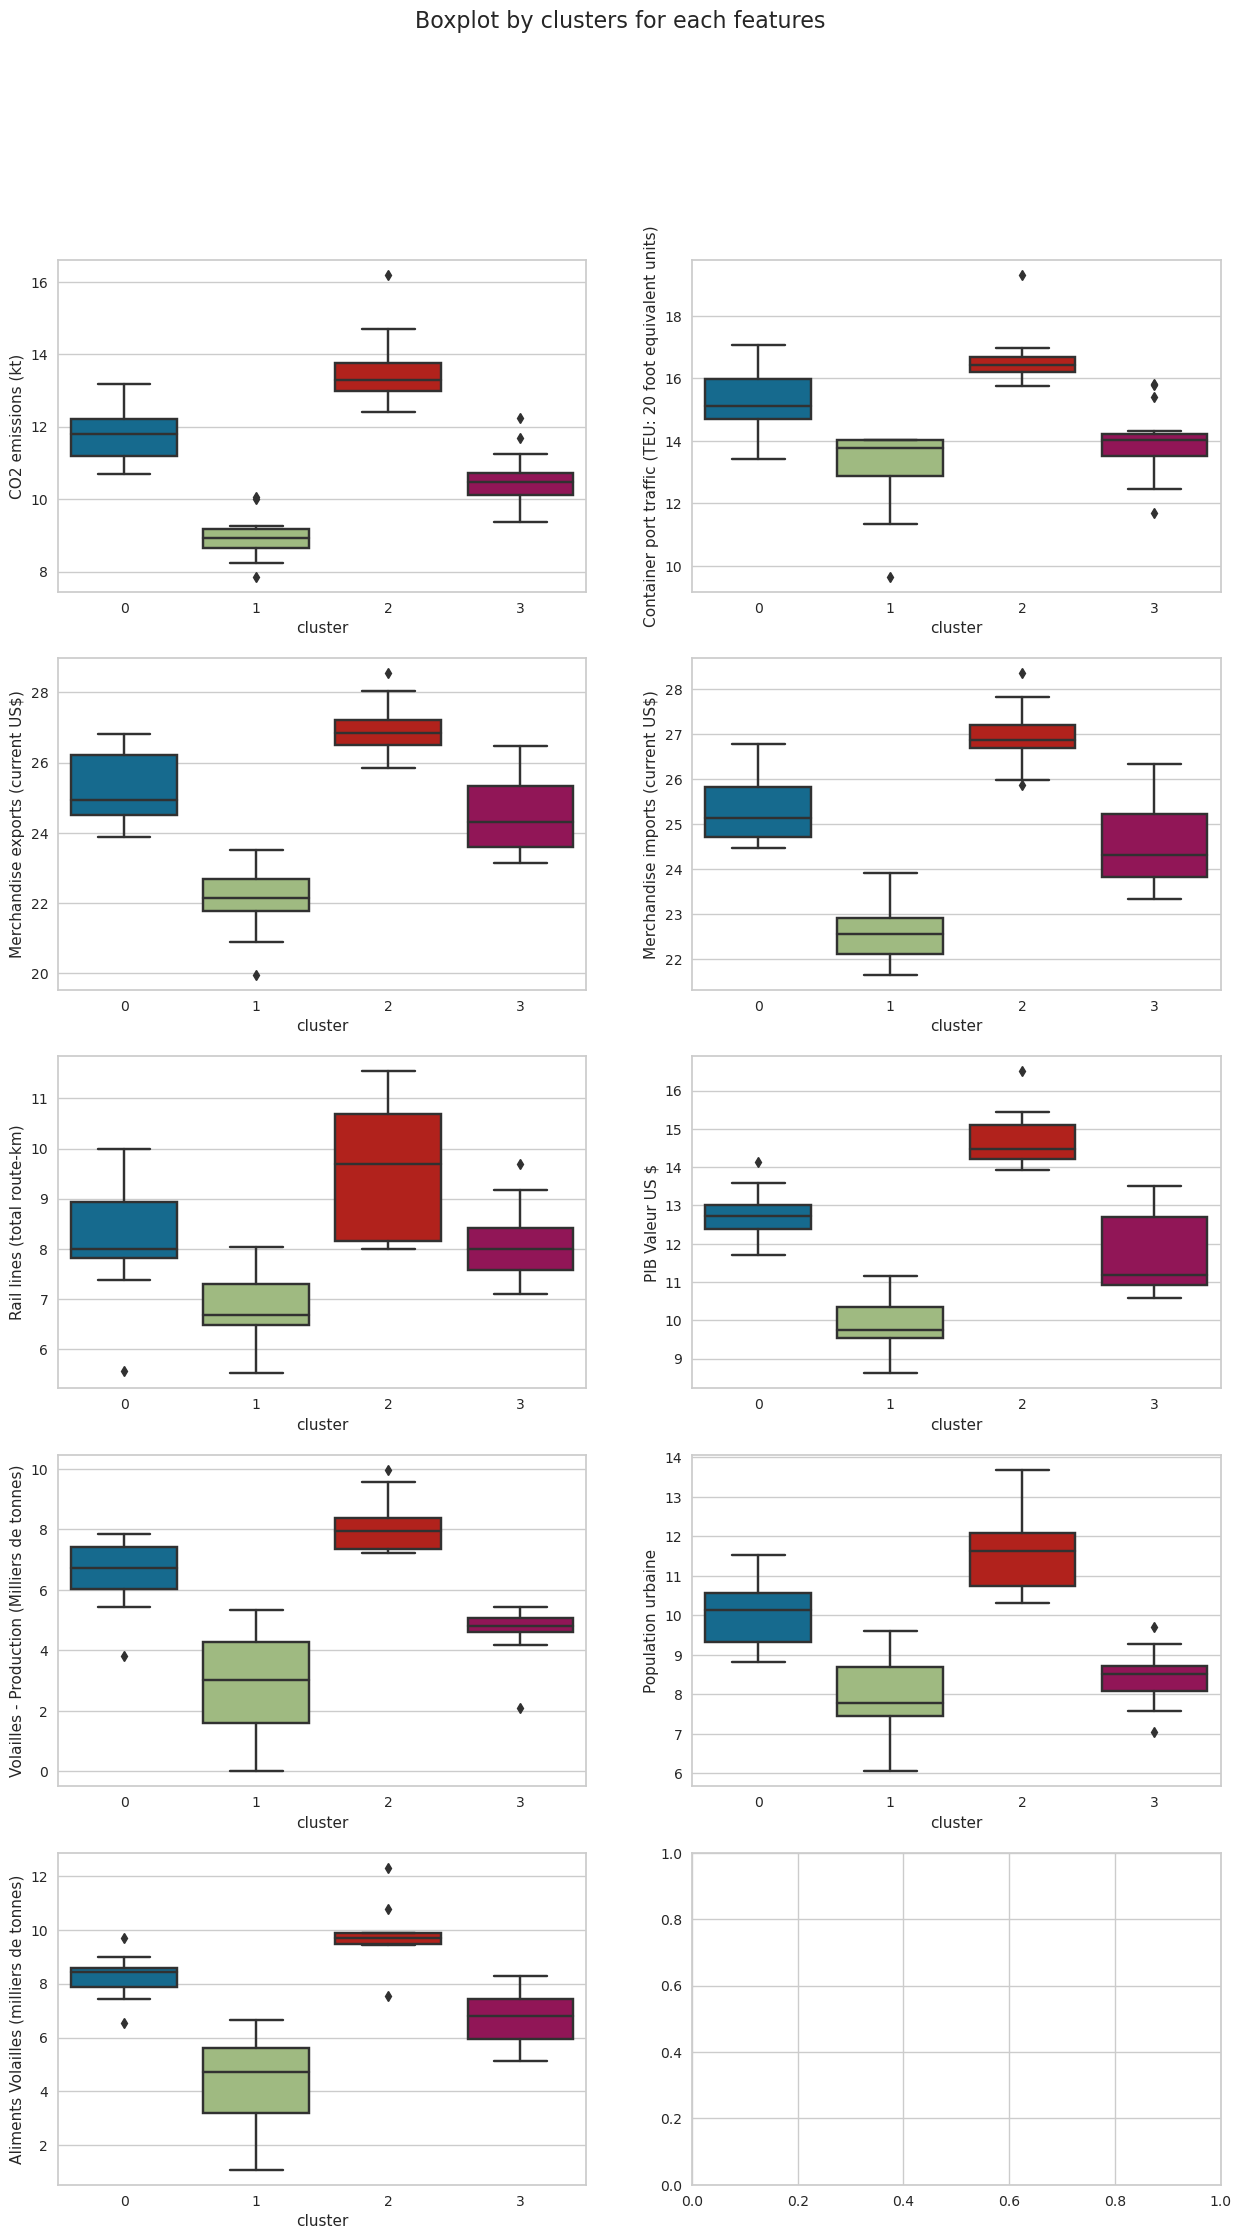

In [86]:
# box plot by clusters for each feature
fig, ax = plt.subplots(5,2,figsize=(15, 25))
sns.boxplot(x="cluster", y="CO2 emissions (kt)", data=km_df, ax=ax[0,0])
sns.boxplot(x="cluster", y="Container port traffic (TEU: 20 foot equivalent units)", data=km_df, ax=ax[0,1])
sns.boxplot(x="cluster", y="Merchandise exports (current US$)", data=km_df, ax=ax[1,0])
sns.boxplot(x="cluster", y="Merchandise imports (current US$)", data=km_df, ax=ax[1,1])
sns.boxplot(x="cluster", y="Rail lines (total route-km)", data=km_df, ax=ax[2,0])
sns.boxplot(x="cluster", y="PIB Valeur US $", data=km_df, ax=ax[2,1])
sns.boxplot(x="cluster", y="Volailles - Production (Milliers de tonnes)", data=km_df, ax=ax[3,0])
sns.boxplot(x="cluster", y="Population urbaine", data=km_df, ax=ax[3,1])
sns.boxplot(x="cluster", y="Aliments Volailles (milliers de tonnes)", data=km_df, ax=ax[4,0])
fig.suptitle('Boxplot by clusters for each features', fontsize=16)

!!!!Rédiger l'Analyse des clusters!!!!

#### Projection des individus sur F1/F2/F3/F4

In [87]:
sns.color_palette()
sns.set_palette("bright")

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


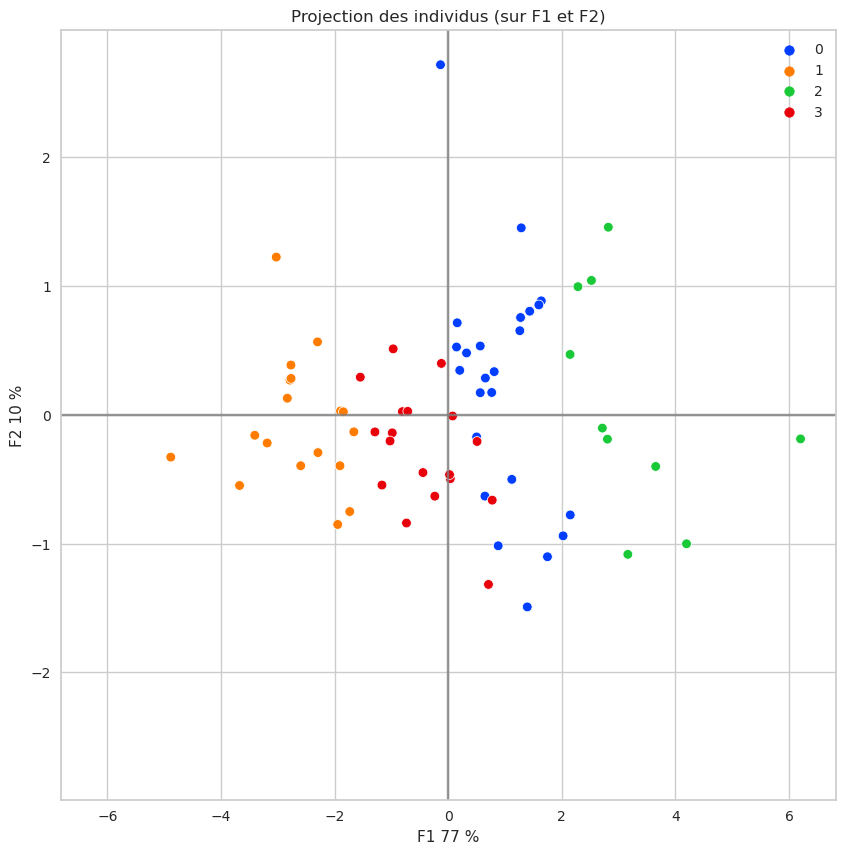

In [88]:
fp1, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,1), clusters=km.clusters)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


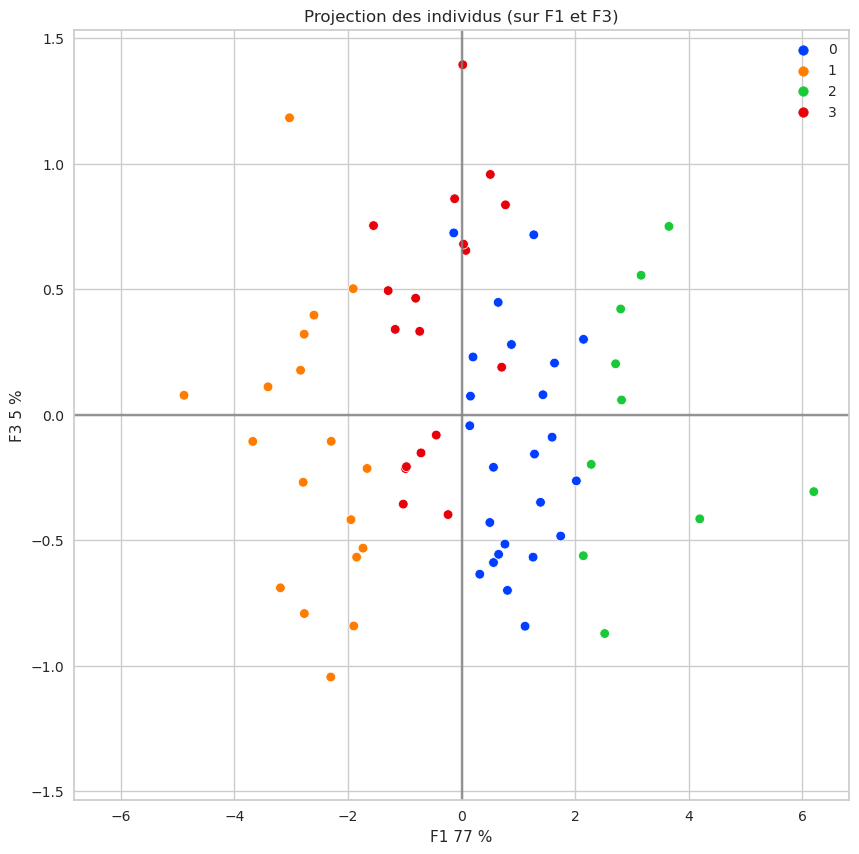

In [89]:
fp2, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,2),clusters=km.clusters)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


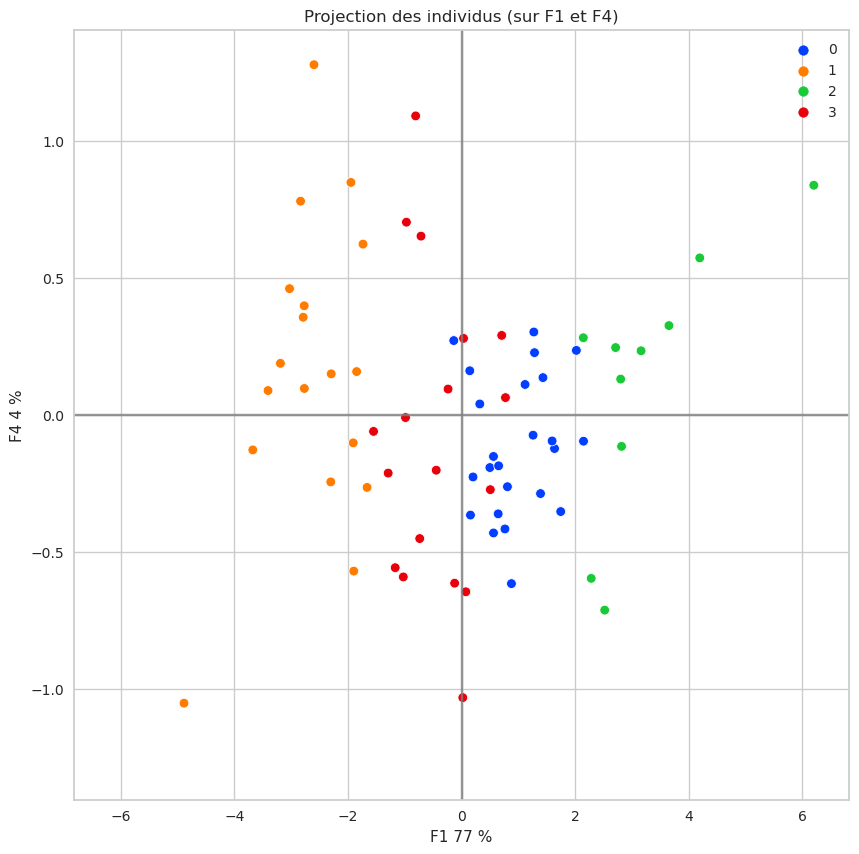

In [90]:
fp3, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(0,3),clusters=km.clusters)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


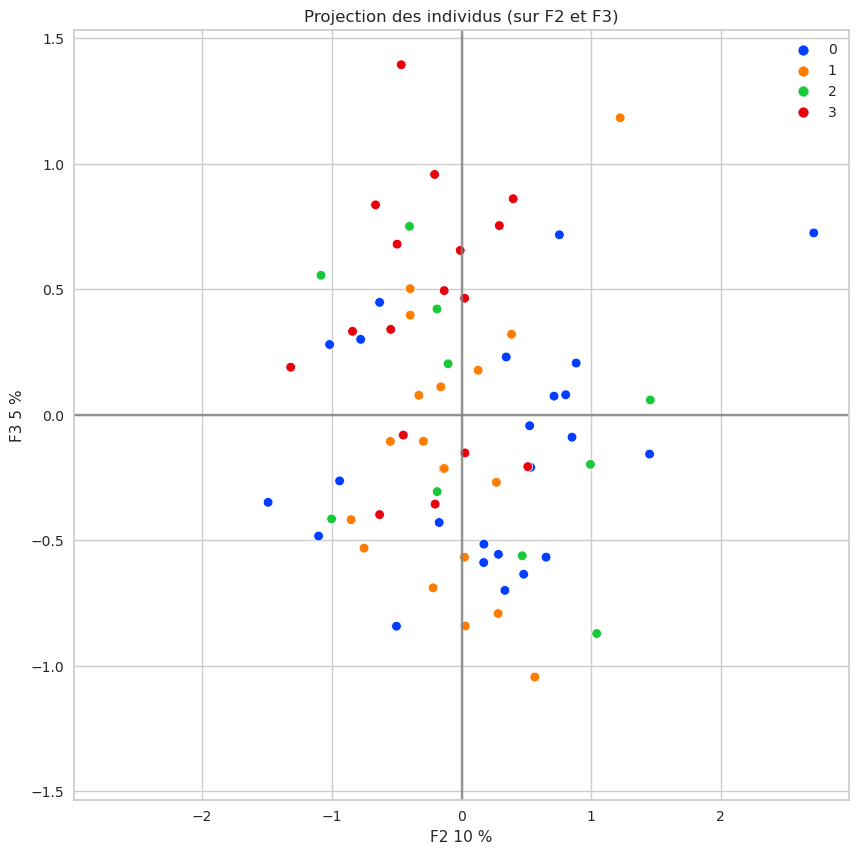

In [91]:
fp4, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,2),clusters=km.clusters)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


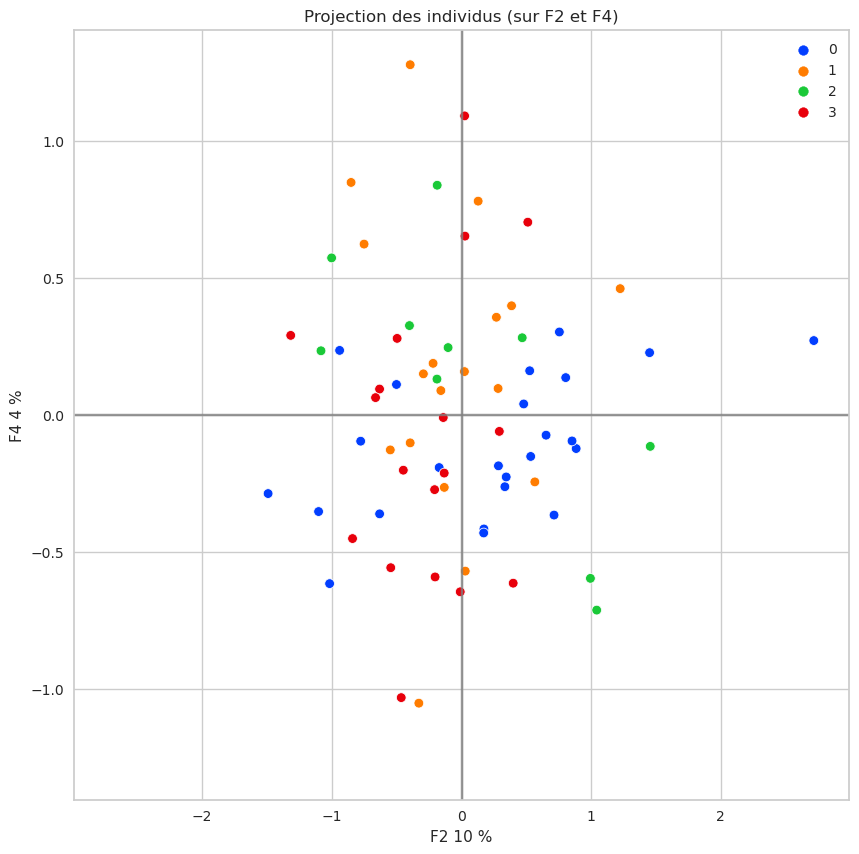

In [92]:
fp5, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(1,3),clusters=km.clusters)

/tmp/ipykernel_178822/2549751352.py:144: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c, palette=sns.color_palette())
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


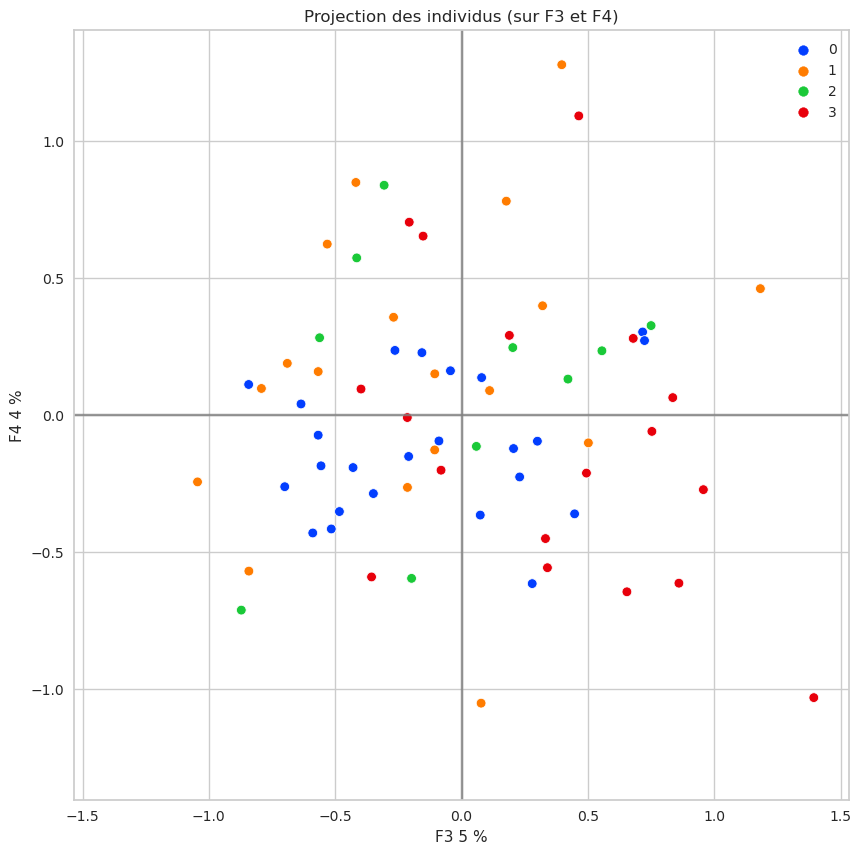

In [93]:
fp6, ax = plt.subplots(figsize=(10, 10))
pca2.display_factorial_planesi(ax,(2,3),clusters=km.clusters)

On remarque une distinction notable sur F1/F2, F1/F3 et F1/F4. Les groupes sont moins flaggrants sur les autres associations de dimensions.